In [178]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import yasa
from scipy.signal import welch
import seaborn as sns
from scipy.signal import welch, freqz, butter, filtfilt
from mne.decoding import CSP
from scipy.signal import savgol_filter
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')


from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB

In [179]:
fs = 100
low = 7
high = 30

events = pd.read_csv('bad code/100Hz/data_set_IVb_al_train_mrk.txt', header=None, sep='\t')
events = np.squeeze(events.values.tolist())

# Import all the electrodes 
electrodes_all = pd.read_csv('bad code/100Hz/data_set_IVb_al_train_nfo.txt', header=None, delimiter=', ', nrows=1, engine='python')
electrodes_all = np.squeeze(electrodes_all.values.tolist())

# use the electrodes that span the motor cortex
first_electrode = np.where(electrodes_all=='CFC7')[0][0]
last_electrode = np.where(electrodes_all=='CCP8')[0][0]

electrodes25 = electrodes_all[first_electrode:last_electrode+1]

C1_ind25 = np.where(electrodes25=='C1')[0][0]
C2_ind25 = np.where(electrodes25=='C2')[0][0]
C3_ind25 = np.where(electrodes25=='C3')[0][0]
C4_ind25 = np.where(electrodes25=='C4')[0][0]
Cz_ind25 = np.where(electrodes25=='Cz')[0][0]

C1_ind = np.where(electrodes_all=='C1')[0][0]
C2_ind = np.where(electrodes_all=='C2')[0][0]
C3_ind = np.where(electrodes_all=='C3')[0][0]
C4_ind = np.where(electrodes_all=='C4')[0][0]
CP1_ind = np.where(electrodes_all=='CP1')[0][0]
CP2_ind = np.where(electrodes_all=='CP2')[0][0]
CP3_ind = np.where(electrodes_all=='CP3')[0][0]
CP4_ind = np.where(electrodes_all=='CP4')[0][0]
FC1_ind = np.where(electrodes_all=='FC1')[0][0]
FC2_ind = np.where(electrodes_all=='FC2')[0][0]
FC3_ind = np.where(electrodes_all=='FC3')[0][0]
FC4_ind = np.where(electrodes_all=='FC4')[0][0]
Cz_ind = np.where(electrodes_all=='Cz')[0][0]

data = pd.read_csv('bad code/100Hz/data_set_IVb_al_train_cnt.txt', names=electrodes_all, delimiter='\t')
data = data.to_numpy()

In [180]:
# CAR referencing

def reference(data):
    assert (data.shape[0] > data.shape[1]), "Check your rows are samples and columns are electrodes: " + str(data.shape)        
    ref = data - np.mean(data, axis = 1, keepdims = True)
    return ref


def butter_bandpass(lowcut, highcut, fs, order=9):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=9):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def plot_spectrum(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd_welch = 10 * np.log10(psd_welch)
        sharey = True
    
    return freqs_welch, psd_welch

In [181]:
data_cz = data - np.reshape(data[:, Cz_ind], (data.shape[0], 1))
data25_cz = data[:, first_electrode: last_electrode+1]

Cz = data[:, Cz_ind]
C1_cz = data[:, C1_ind] - Cz #Cz reference has been the best!
C2_cz = data[:, C2_ind] - Cz
C3_cz = data[:, C3_ind] - Cz
C4_cz = data[:, C4_ind] - Cz

selected_electrodes = (np.vstack((C1_cz, C2_cz, C3_cz, C4_cz))).T
channels = selected_electrodes.shape[1]

print(selected_electrodes.shape)


(210259, 4)


<IPython.core.display.Javascript object>


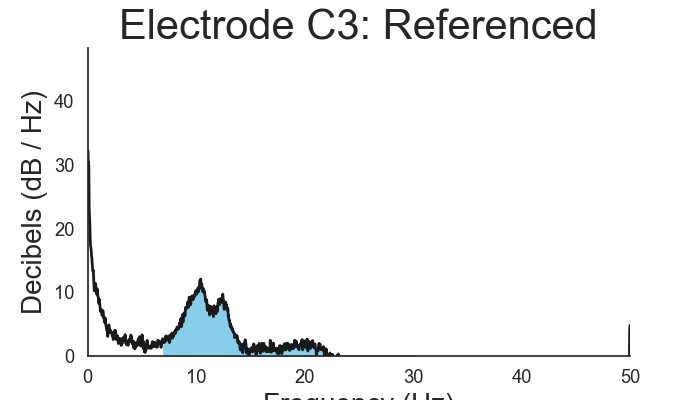

{False, True}


In [182]:
freqs, psd = plot_spectrum(C3_cz, fs, (32), [1, 50], dB=True)

# Define mu band
# Find intersecting values in frequency vector
idx_mu = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_mu, color='skyblue')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Decibels (dB / Hz)', fontsize=20)
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.5])
plt.title("Electrode C3: Referenced", fontsize=30)
sns.despine()

print(set(freqs == 7))

In [185]:
start = events[0][0]
zeros = 50 # Lower resolution work best
sec = 1

C3_t1 = C3_cz[start: start + int(sec*fs)]
C3_t1_pad = np.pad(C3_t1, [(zeros, zeros)], mode='constant')

# t = range(1,201)
# plt.figure(figsize=(7, 4))
# plt.plot(t, C3_t1,color='m')
# plt.title("C3: First trial", fontsize=30)

freqs, psd = plot_spectrum(C3_t1_pad, fs, (32), [1, 50], dB=True)
print(freqs)
# plt.figure(figsize=(7, 4))
# plt.plot(freqs, psd,color='b')
# plt.title("C3: First trial frequency domain", fontsize=30)

low_ind = np.where(freqs == low)[0][0]
high_ind = np.where(freqs == high)[0][0]

psd_sliced = psd[low_ind: high_ind]
freqs_sliced = freqs[low_ind: high_ind]

print(psd_sliced)
# psd_sliced_half = [psd_sliced[i] for i in range(0, len(psd_sliced), 2)]
# freqs_sliced_half = [freqs_sliced[i] for i in range(0, len(freqs_sliced), 2)]

# print(len(freqs_sliced), len(freqs_sliced_half))

# plt.figure(figsize=(7, 4))
# plt.plot(freqs_sliced, psd_sliced,color='r')
# plt.title("C3: First trial sliced frequency domain", fontsize=30)

n_freqs = len(psd_sliced)
print(n_freqs)

# print(low_ind, high_ind)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5
 49.  49.5 50. ]
[  4.15950687   3.08375891   1.07720074   0.30078132   4.74093122
   5.54866255   8.37482878   3.51051246  -0.47703676   5.74046491
   5.13043928   0.43805076  -2.21125534  -0.12622564  -0.73271347
   2.72254213   4.19212738   1.37349314  -4.57571451  -0.39419534
   1.4023162   -2.54644227  -8.4343576  -14.06694197   0.42688034
   0.38334179  -0.83855874   1.72227453  -8.42420914  -0.30082832
   7.21255951   7.30420524   5.28182243   5.67036756  -4.10960772
 -11.70418134  -2.349690

In [186]:
def psd_of_window(trial, n_freqs, zeros, fs, low, high):
    channels = trial.shape[1]
    temp = np.zeros((channels, n_freqs))
    
    for j in range(channels):
        trial_pad = np.pad(trial[:, j], [(zeros, zeros)], mode='constant')
        freqs, psd = plot_spectrum(trial_pad, fs, (32), [low, high], dB=True)

        low_ind = np.where(freqs == low)[0][0]
        high_ind = np.where(freqs == high)[0][0]

        psd_sliced = psd[low_ind: high_ind]
        freqs_sliced = freqs[low_ind: high_ind]

        temp[j, :] = psd_sliced

    return np.ravel(temp)

In [187]:
# Create training data

def create_data(data, fs, low, high, n_freqs, trials, sec, gap, gap2, zeros):
    channels = data.shape[1]
    y = []
    rest_row = 0
    x = np.zeros((trials, channels*n_freqs))
    x1 = np.zeros((trials, channels*n_freqs))
    temp = np.zeros((channels, n_freqs))
    rest = np.zeros((trials, channels*n_freqs))
    print(x.shape, temp.shape)
    
    win = round(sec*fs)
    
    for i in range(trials):
        event = events[i]
        if (event[1] == 1):
            y.append(1)
        else:
            y.append(-1)
            
        all_channel_trial = data[event[0]+(gap2*fs):event[0]+win+(gap2*fs), :]
        
        x[i, :] = psd_of_window(all_channel_trial, n_freqs, zeros, fs, low, high)
         
        
    rest_row = 0
    for i in range(trials):
        event = events[i]
        if (event[1] == 1):
            y.append(1)
        else:
            y.append(-1)
            
        all_channel_trial = data[event[0]+(-1+gap2*fs):event[0]+win+(-1+gap2*fs), :]
        
        x1[i, :] = psd_of_window(all_channel_trial, n_freqs, zeros, fs, low, high)
        
        
        # Get some rest 
        all_channel_trial = data[event[0]+int((3.5+gap)*fs):event[0]+int((3.5+gap+sec)*fs), :]

        rest[rest_row, :] = psd_of_window(all_channel_trial, n_freqs, zeros, fs, low, high)
        rest_row += 1
    
    
    x = np.vstack((x, x1))
    x = np.vstack((x, rest))
    y = y + (np.zeros((trials))).tolist()
    
        
    return x, y
            
    

x, y = create_data(selected_electrodes, fs, low, high, n_freqs, 210, 1, 0.75, 1, zeros) 
print(x.shape, len(y))
print(x)
print(y)
# 0: 1Hz res
# 50: 0.5Hz res
# 150: 0.25Hz res
# 450: 0.1Hz res

(210, 184) (4, 46)
(630, 184) 630
[[ -5.60920218   5.43152941   1.27012726 ...  -0.14964202   1.23614259
   -1.31258296]
 [ -2.15665939  -0.9941026   -4.75034737 ...  -4.02996011  -6.09660343
    0.12132436]
 [  1.98759615   0.48358714   0.86673228 ...  -2.24777715  -3.92496604
   -6.44386775]
 ...
 [  3.99835685   8.37197714   5.03649131 ...  -6.90611918 -18.67530653
   -2.18481181]
 [ -1.13221035  -0.44628889  -2.47937692 ... -15.10892901  -9.05456881
   -4.10616431]
 [  1.66569105   1.75949608   2.07465535 ... -10.08454453 -12.90323289
   -1.3964469 ]]
[1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1

In [188]:
# # Convert to pandas df
# x_df = pd.DataFrame(x)
# x_train, x_test, y_train, y_test = train_test_split(x_df, y, train_size=0.6, shuffle=True, stratify=None)

# # Preprocess
# scaler = StandardScaler()
# scaler.fit(x_train)    
# x_train = scaler.transform(x_train)
# x_test = scaler.transform(x_test)

# quantile_transformer = QuantileTransformer(random_state=0)
# x_train = quantile_transformer.fit_transform(x_train)
# x_test = quantile_transformer.transform(x_test)

# # Run the model
# model = SVC(kernel='poly')
# model = ComplementNB()
# model = MultinomialNB()
# model = CategoricalNB()
# model.fit(x_train, y_train)

# # Make predictions on entire test set
# predictions = model.predict(x_test)

# # Use score method to get accuracy of model
# score = model.score(x_test, y_test)

# # Confusion matrix
# cm = metrics.confusion_matrix(y_test, predictions)
# print(cm)

# # Plot confusion matrix
# plt.figure(figsize=(9,9))
# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", score)
# plt.title(all_sample_title, size = 15);

In [189]:
quantile_transformer = QuantileTransformer(random_state=0)
x_1 = quantile_transformer.fit_transform(x)


Accuracy: 83.65 (+/- 0.25)


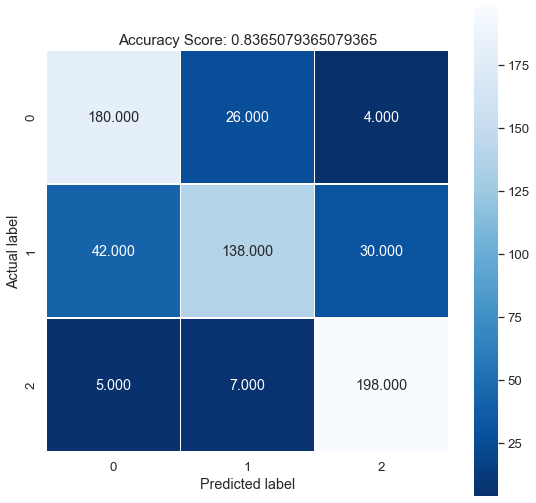

In [30]:
cm = metrics.confusion_matrix(y, cross_val_predict(MLPClassifier(hidden_layer_sizes=(300,100,50)), x_1, y, cv=KFold(x.shape[0]))

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title(all_sample_title, size = 15);

In [87]:
scores = cross_val_score(GaussianNB(), x_1, y, cv=KFold(x.shape[0])) 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

Accuracy: 71.90 (+/- 0.90)


Accuracy: 86.98 (+/- 0.67)


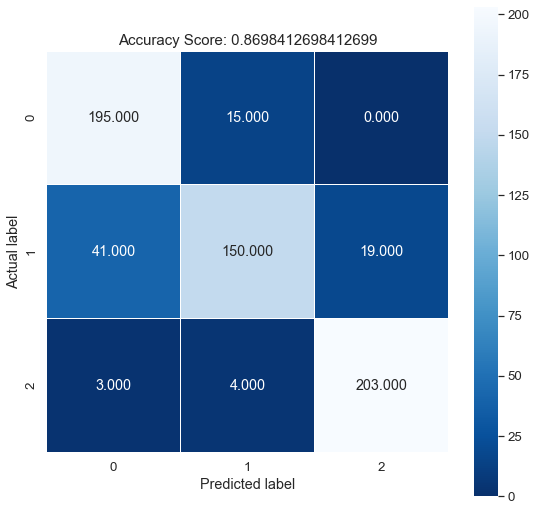

In [32]:
scores = cross_val_score(SVC(kernel='poly', degree=2), x_1, y, cv=KFold(x.shape[0])) # Best so far 78% 2sec 100Hz
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

cm = metrics.confusion_matrix(y, cross_val_predict(SVC(kernel='poly', degree=2), x_1, y, cv=KFold(x.shape[0])))

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", scores.mean())
plt.title(all_sample_title, size = 15);

In [190]:
scores = cross_val_score(SVC(kernel='poly', degree=3), x, y, cv=KFold(x.shape[0])) # 2nd Best so far 90%
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

Accuracy: 71.75 (+/- 0.90)


Accuracy: 86.83 (+/- 0.68)


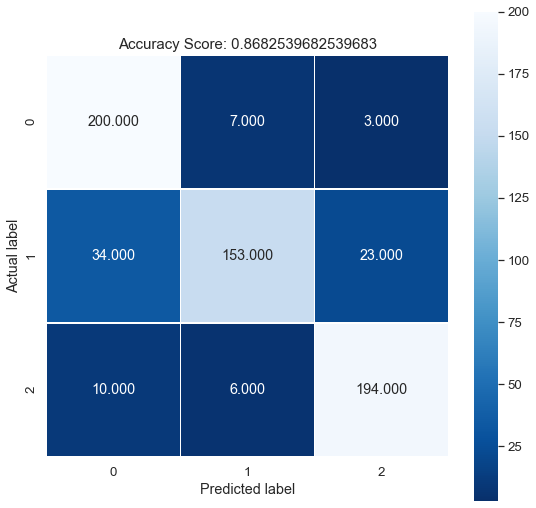

In [106]:
scores = cross_val_score(SVC(kernel='rbf'), x_1, y, cv=KFold(x.shape[0])) 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

cm = metrics.confusion_matrix(y, cross_val_predict(SVC(kernel='rbf'), x_1, y, cv=KFold(x.shape[0])))

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", scores.mean())
plt.title(all_sample_title, size = 15);

In [ ]:
scores = cross_val_score(LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen'), x_1, y, cv=KFold(x.shape[0]))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

cm = metrics.confusion_matrix(y, cross_val_predict(LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen'), x_1, y, cv=KFold(x.shape[0])))

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", scores.mean())
plt.title(all_sample_title, size = 15);

In [193]:
scores = cross_val_score(LogisticRegression(max_iter=1000), x, y, cv=KFold(x.shape[0]))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean() * 100, scores.std()*2))

Accuracy: 69.21 (+/- 0.92)


# Predict shit

In [65]:
quantile_transformer = QuantileTransformer(random_state=0).fit(x)
x_1 = quantile_transformer.transform(x)

x_test = x_1[207:210, :]
y_test = y[207:210]

x_train = np.delete(x_1, [207, 208, 209], axis=0)
y_train = y[0:207] + y[210:]

print(x_train.shape, len(y_train))

(627, 184) 627


In [190]:
model = SVC(kernel='rbf')
# model = SVC(kernel='rbf')
model.fit(x_train, y_train)

SVC()

In [191]:
# Make predictions on some samples
predictions = model.predict(x_1[207:210, :])
print(predictions)
# Use score method to get accuracy
score = model.score(x_test, y_test)

print(score)

[ 1.  1. -1.]
1.0


In [192]:
# Grab the last trial + the rest surrounding it
start = events[-1][0]
last_trial = selected_electrodes[start-175:start+525, :] # 7 seconds

start = events[-2][0]
second_to_last_trial = selected_electrodes[start-175:start+525, :]
print(last_trial.shape)

(700, 4)


In [193]:
def predict_stuff(trial, model):
    output = []
    a = 0
    b = 100
    inc = 1
    
    while (b < last_trial.shape[0]):
        win = trial[a:b, :]
        features = psd_of_window(win, n_freqs, zeros, fs, low, high)
        features = np.reshape(features, (1, -1))
        output.append(model.predict(features)[0])
        
        a += 1
        b += 1
    
    return output

<IPython.core.display.Javascript object>


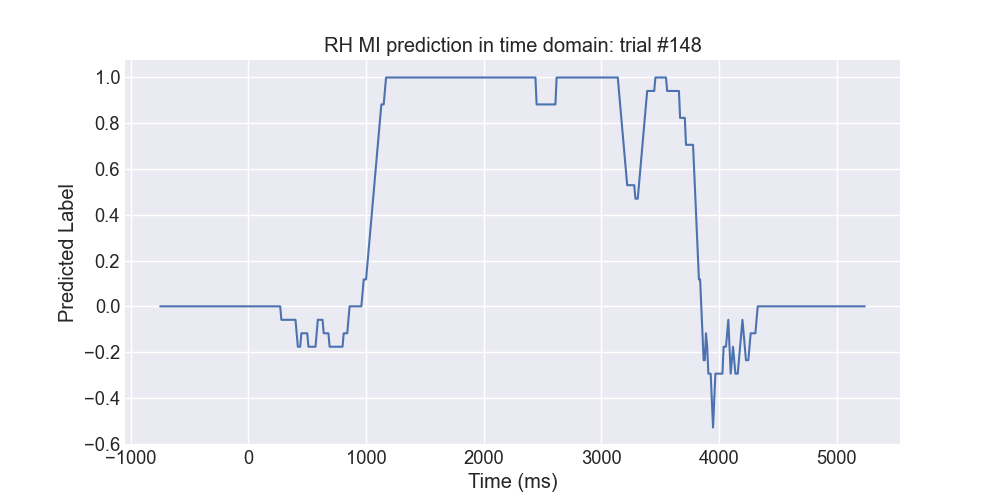

(600,)
CPU times: user 10.9 s, sys: 164 ms, total: 11.1 s
Wall time: 11.2 s


In [194]:
%%time
from scipy.ndimage import gaussian_filter1d

def plot_MI_predictions(trial, model, quantile_transformer, stp, ind):
    output = []
    a = 0
    b = 100
    
    while (b < trial.shape[0]):
        win = trial[a:b, :]
        
        features = psd_of_window(win, n_freqs, zeros, fs, low, high)
        features = np.reshape(features, (1, -1))
        features = quantile_transformer.transform(features)
        
        output.append(model.predict(features)[0])
        
        a += int(stp/10)
        b += int(stp/10)
        
    smoothed = savgol_filter(output, 17, 1)
    sigma = 4
#     smoothed = gaussian_filter1d(output, sigma)
    
    interval_size = int((trial.shape[0] - 100)/int(stp/10))
    time = range(-750, 5250, int(6000/interval_size))
    
    sns.set(font_scale=1.2, style='white')
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(10, 5))
    plt.plot(time, smoothed)
    plt.xlabel('Time (ms)')
    plt.ylabel('Predicted Label')
    
    if (events[ind][1] == 1):
        MI_type = "RH"
    else:
        MI_type = "LH"
    
    if (ind != None):
        plt.title(MI_type + " " + "MI prediction in time domain: " + "trial #"  + str(ind+1))
    else:
        plt.title("MI prediction in time domain")
    
    plt.savefig("Graphs/predictions/SVM_rbf_gaussian/Trial #" + str(ind+1) + '.png')
    sns.despine()
    
    return smoothed

smoothed = plot_MI_predictions(trial_148, model, quantile_transformer, 10, 147) # stp is in ms
print(smoothed.shape)

(210, 184) (4, 46)


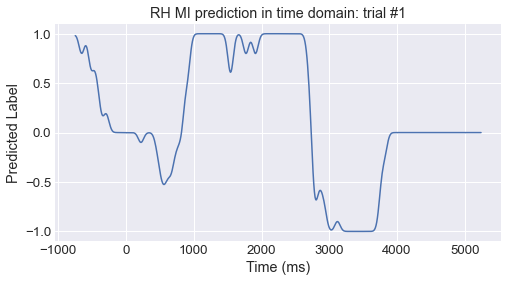

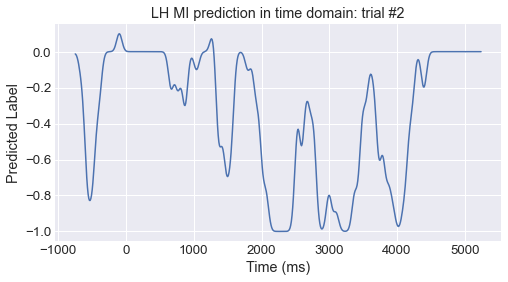

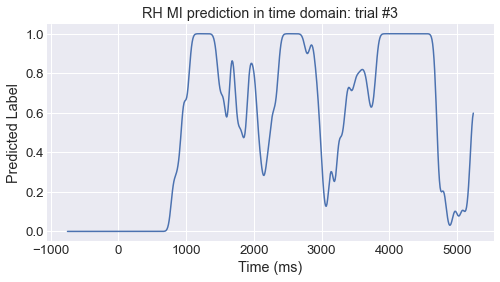

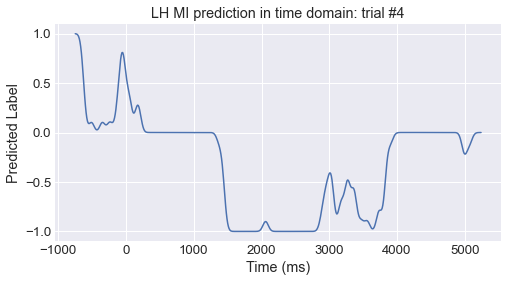

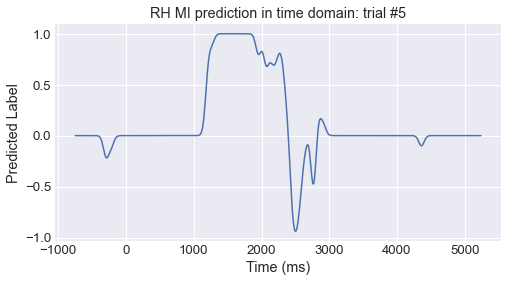

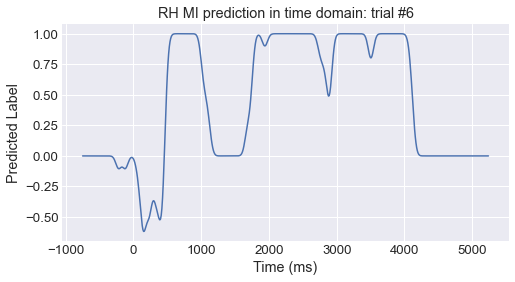

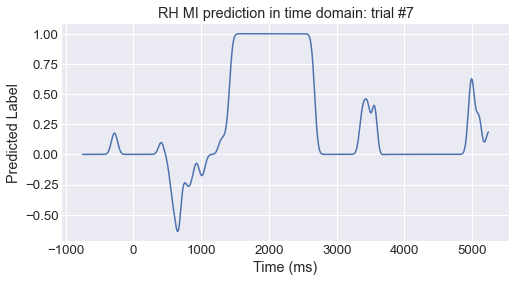

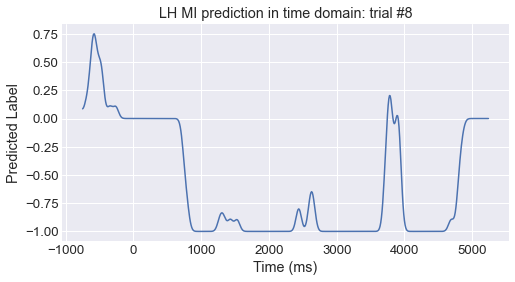

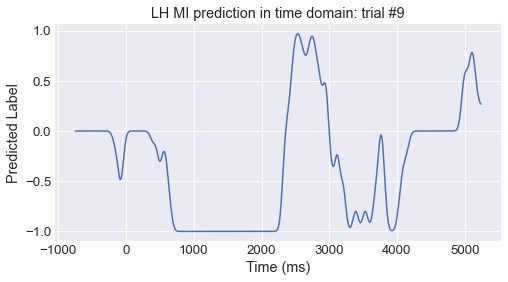

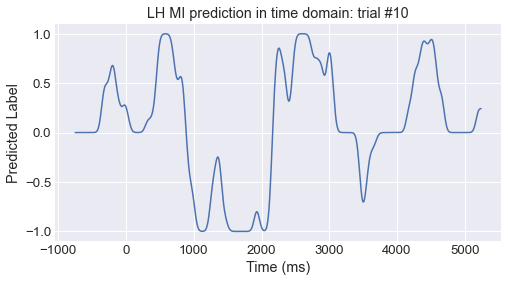

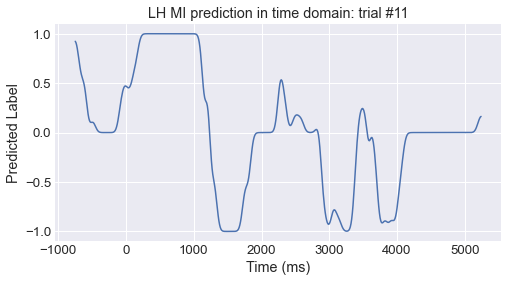

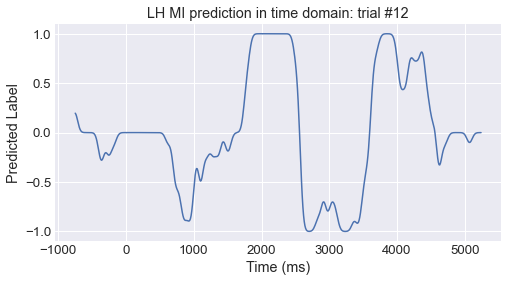

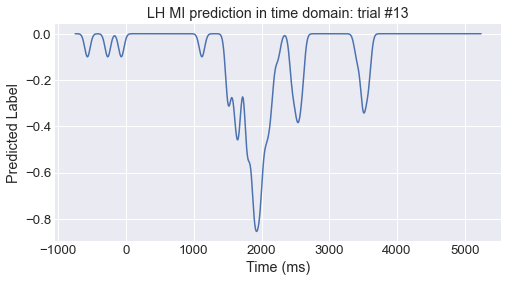

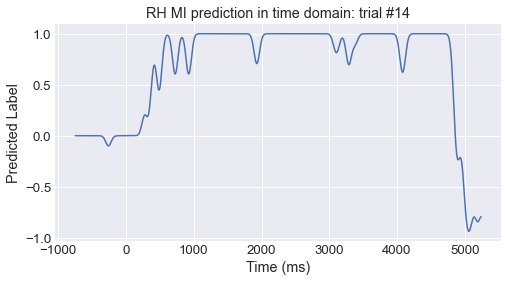

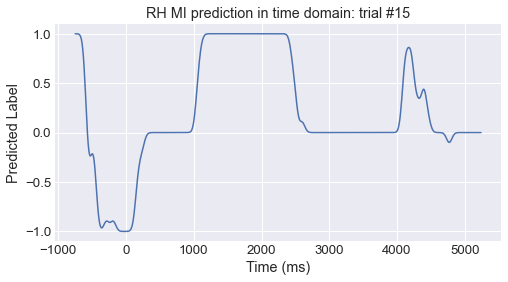

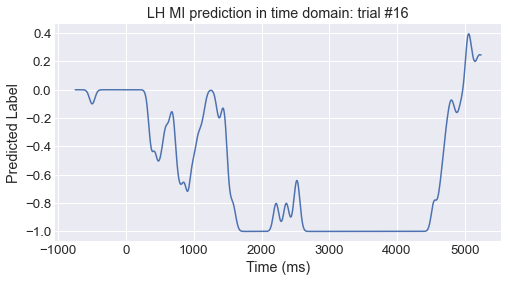

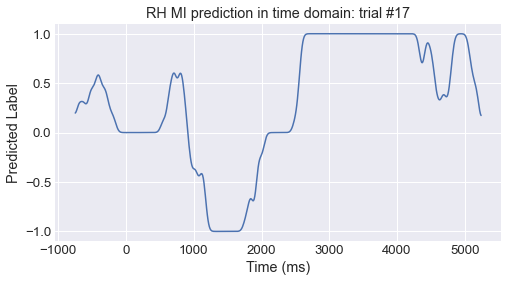

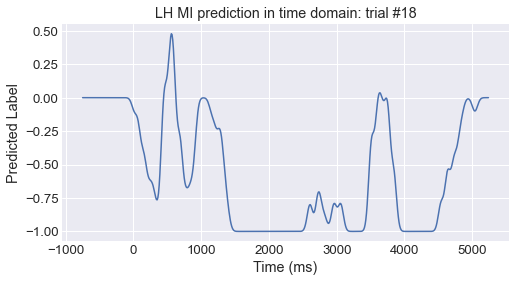

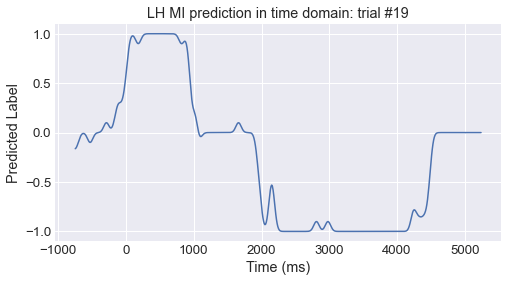

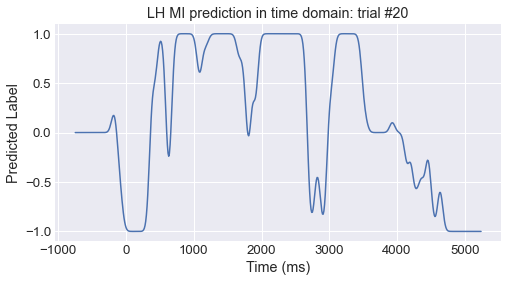

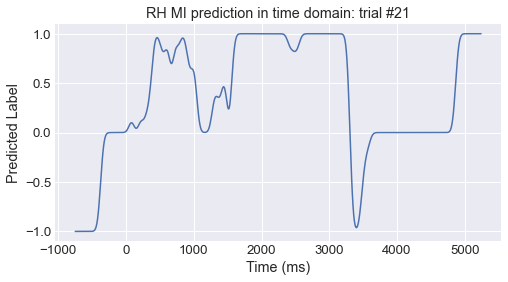

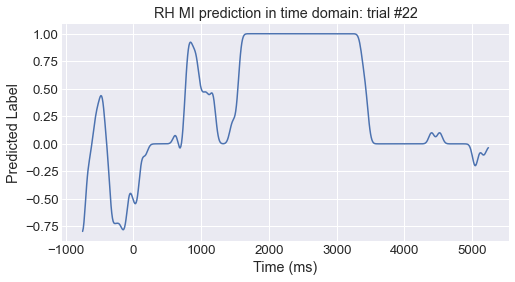

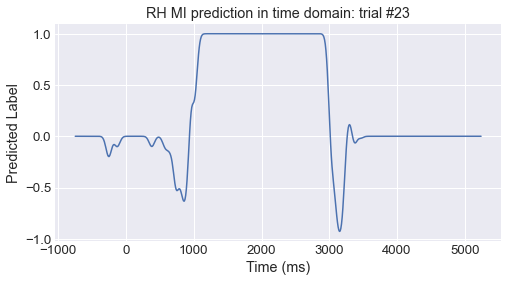

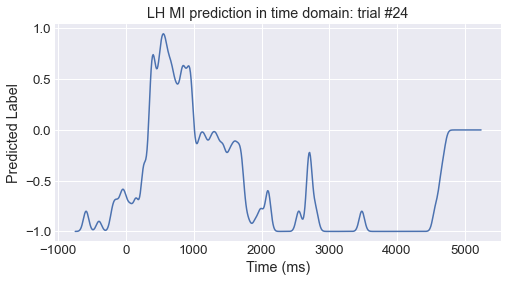

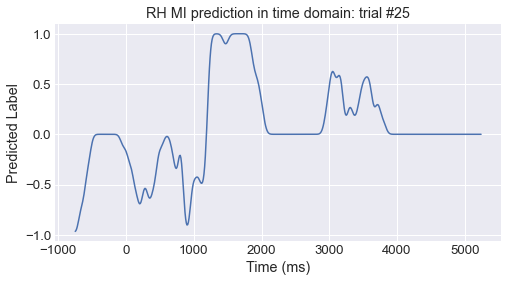

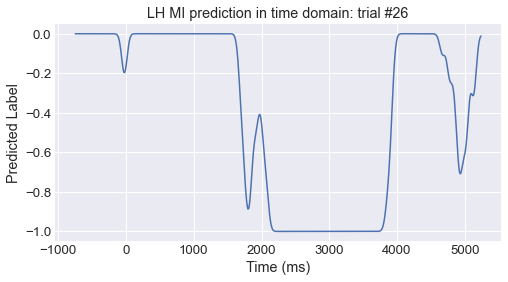

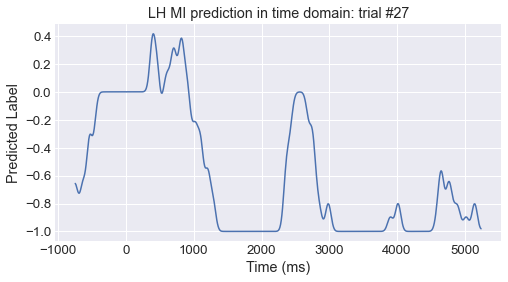

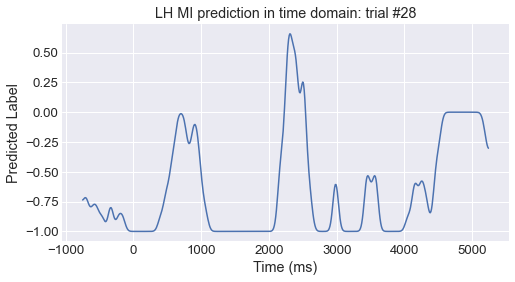

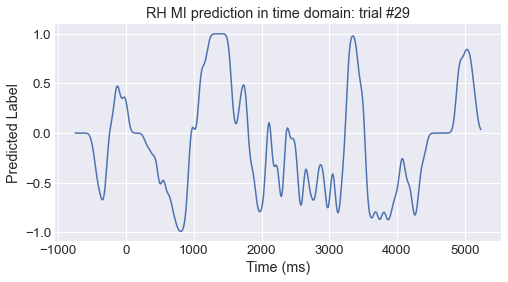

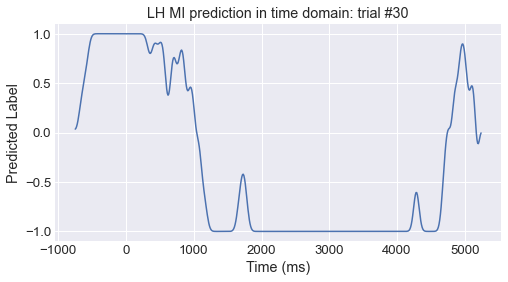

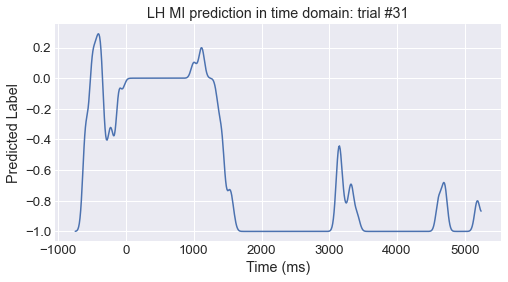

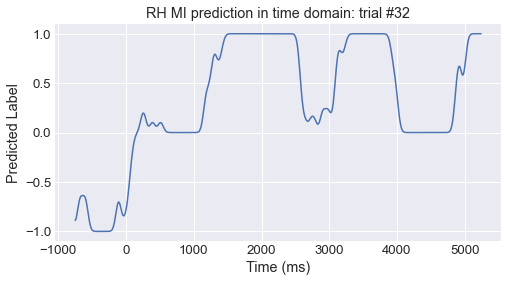

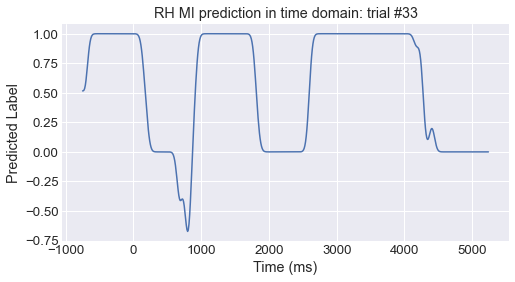

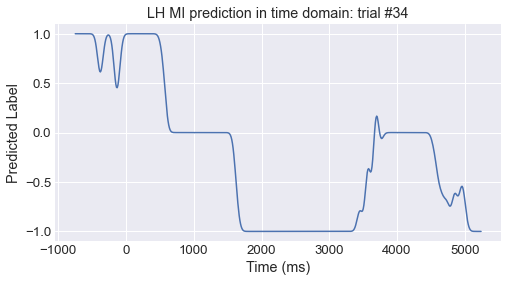

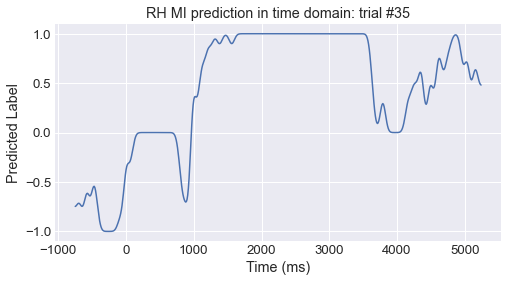

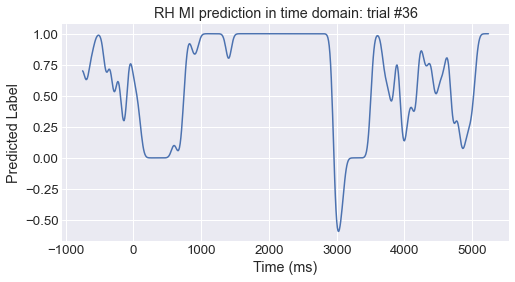

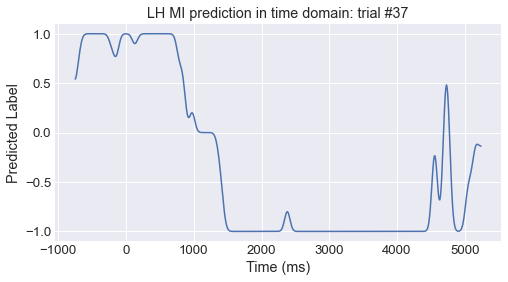

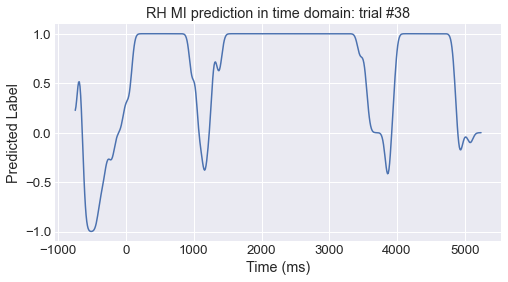

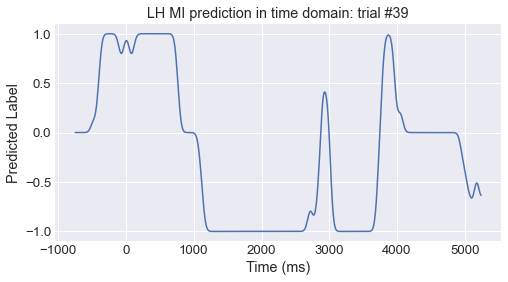

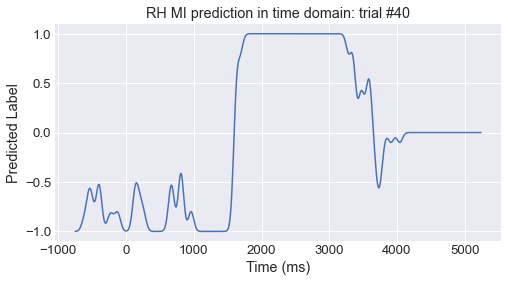

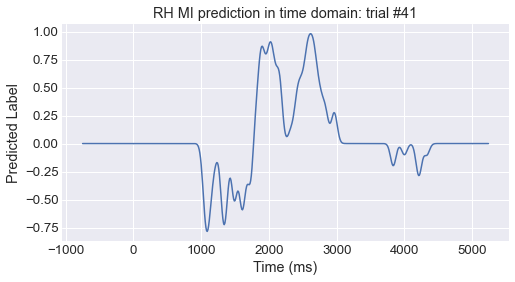

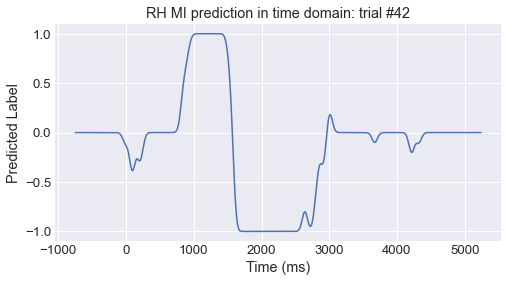

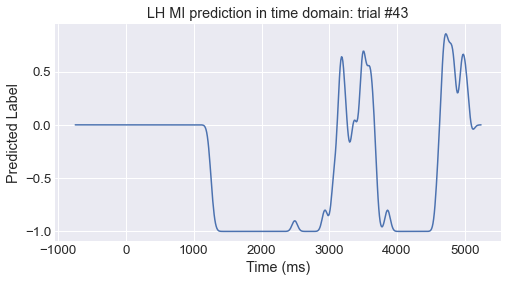

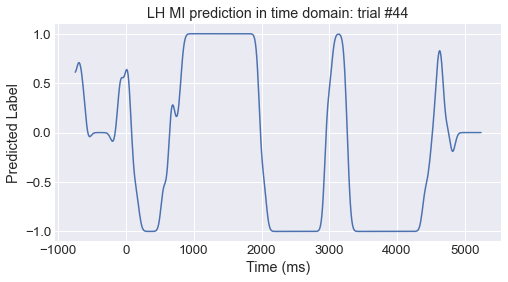

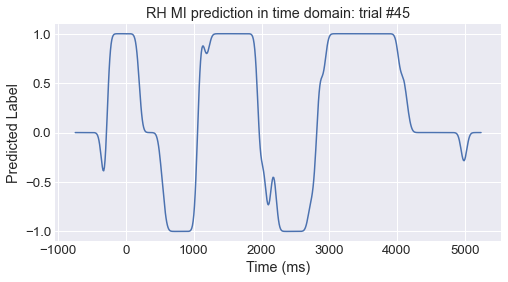

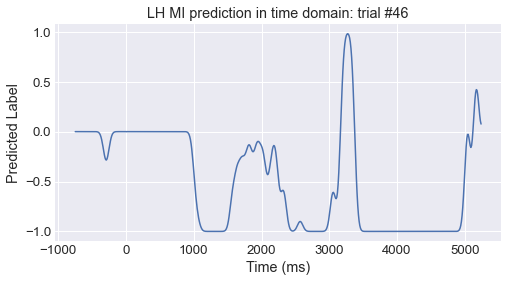

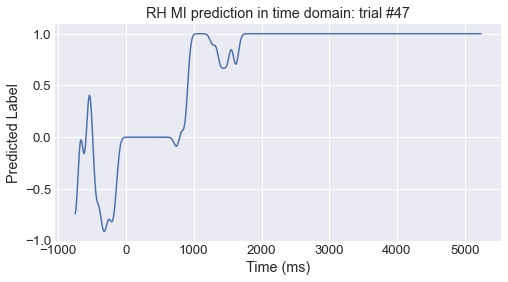

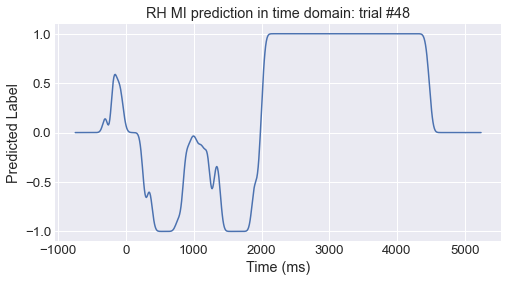

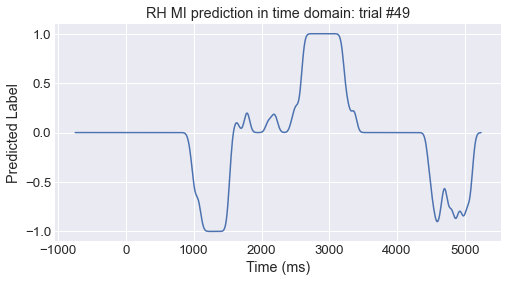

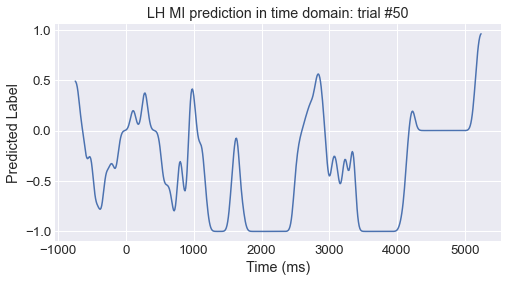

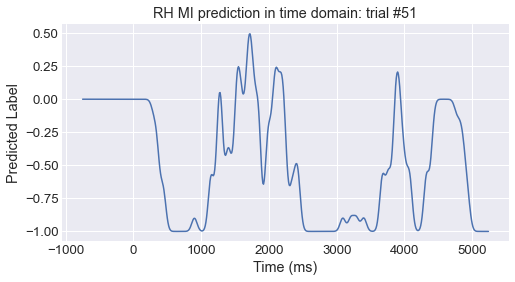

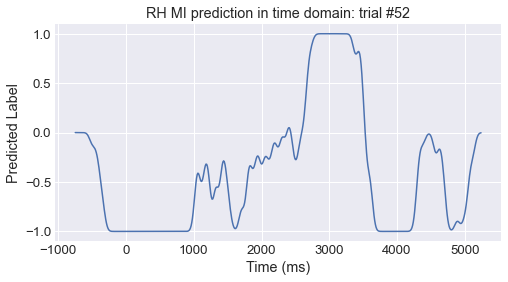

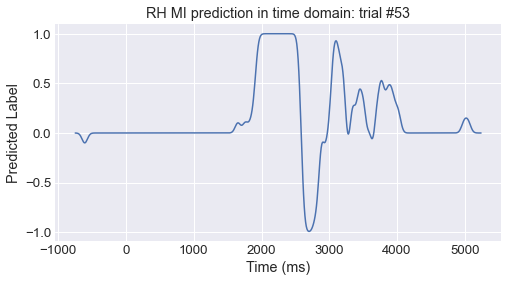

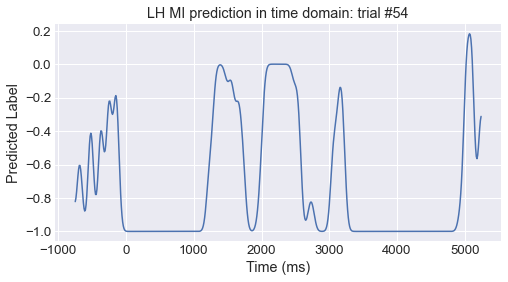

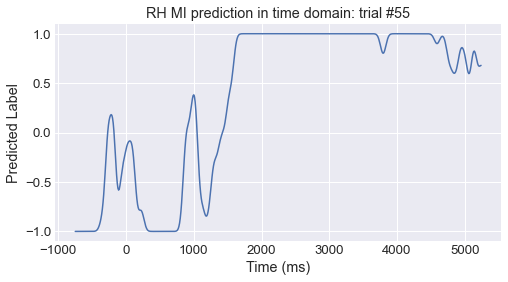

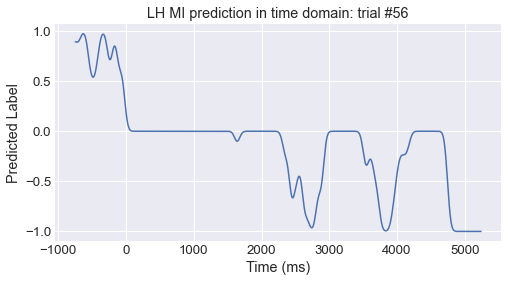

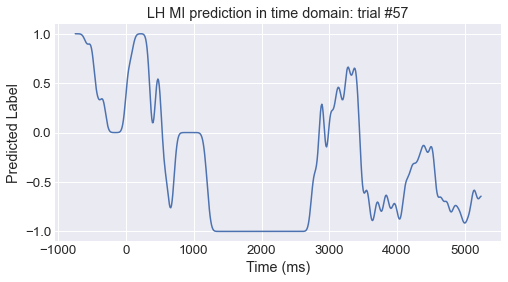

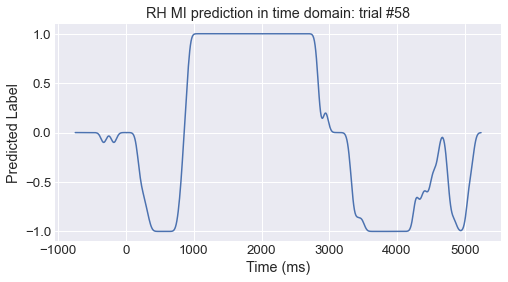

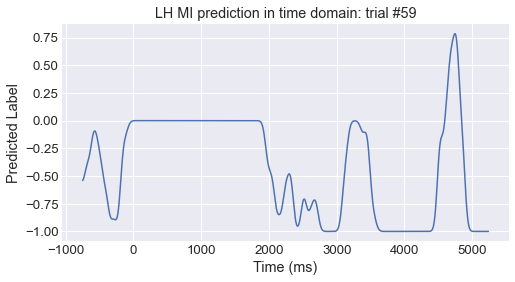

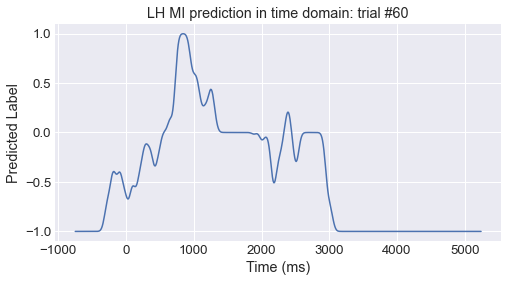

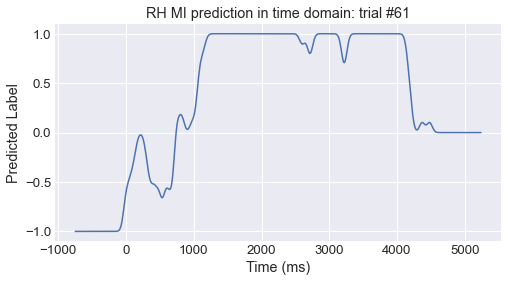

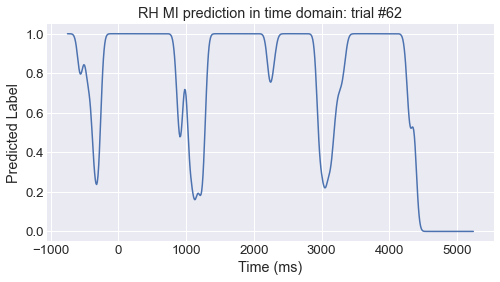

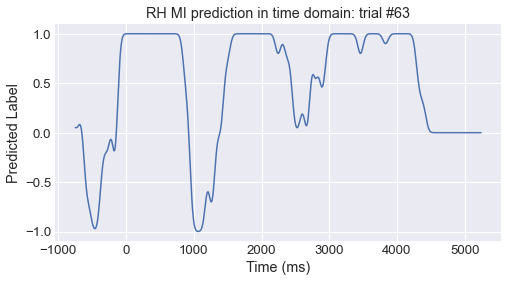

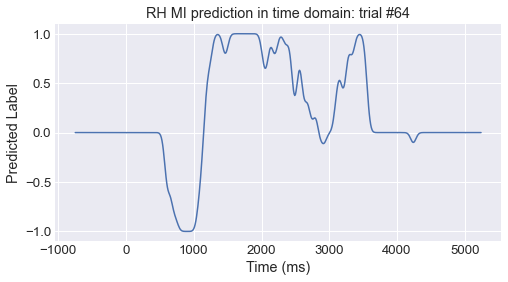

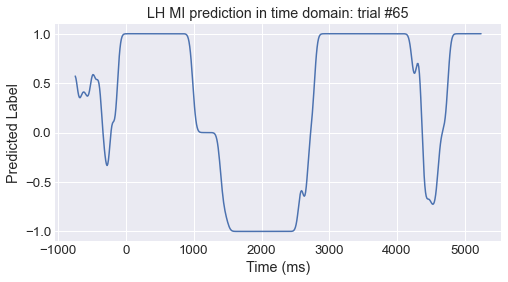

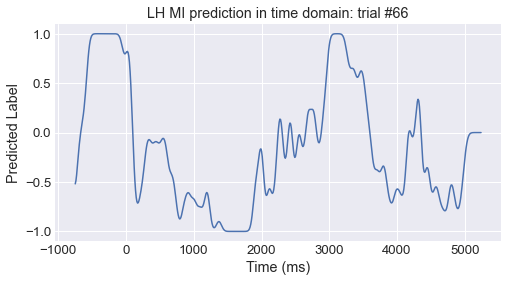

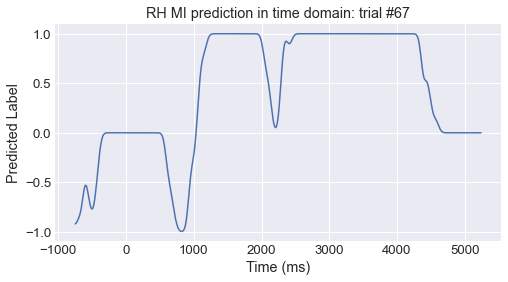

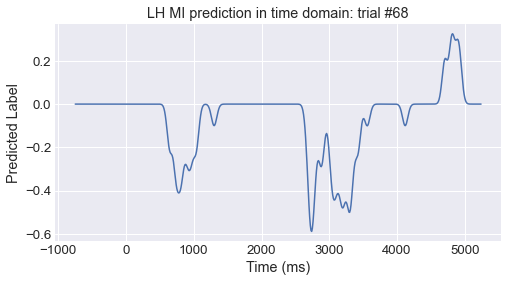

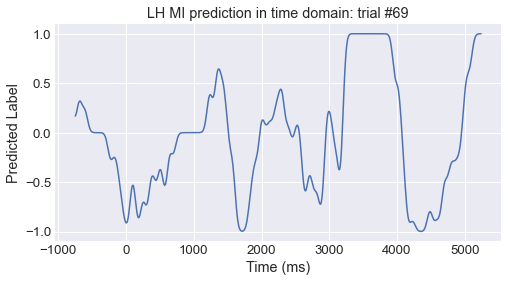

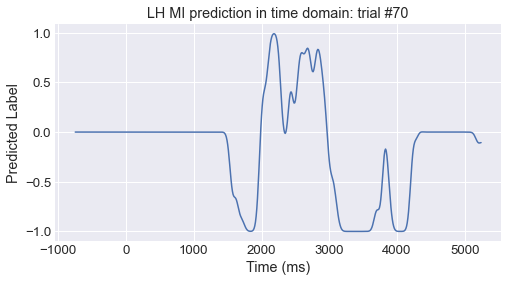

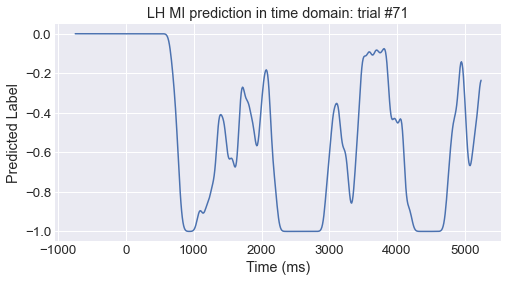

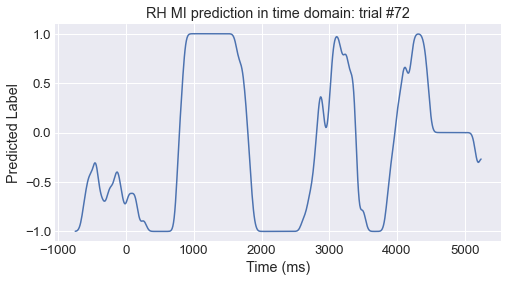

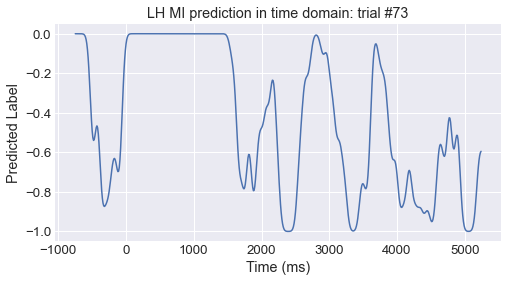

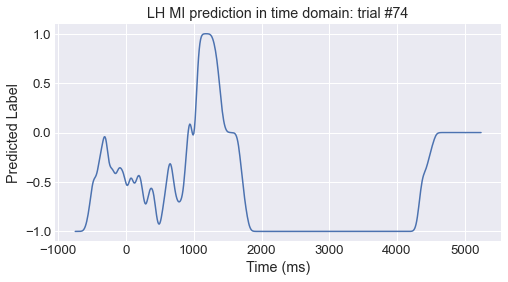

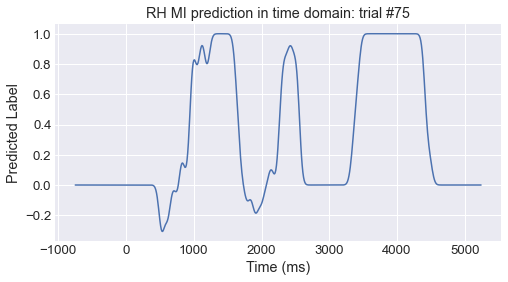

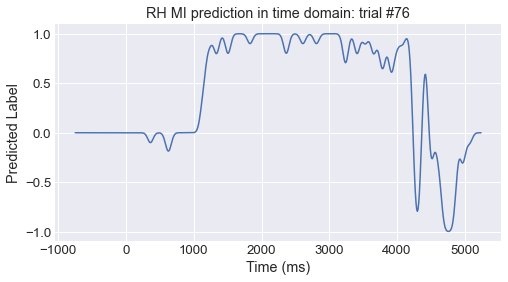

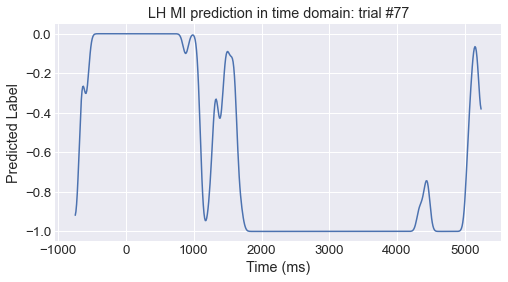

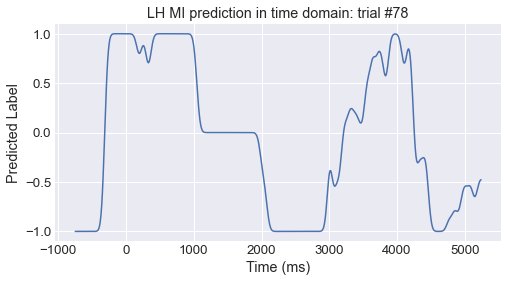

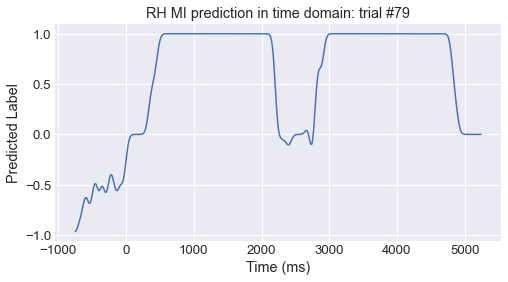

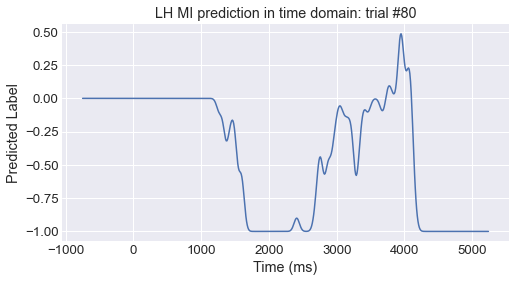

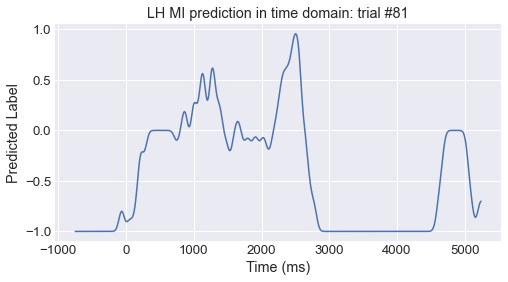

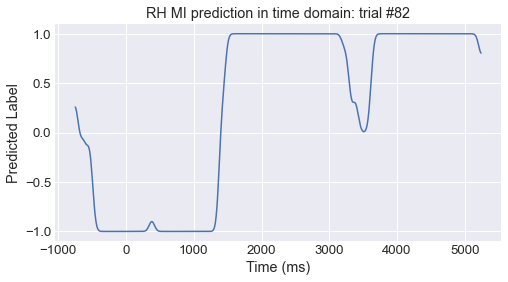

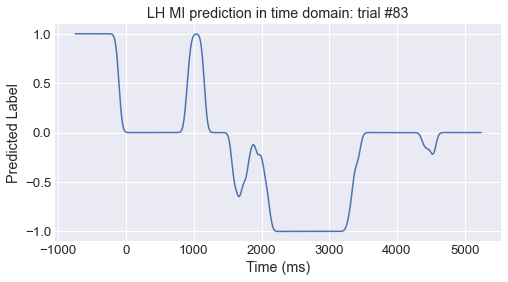

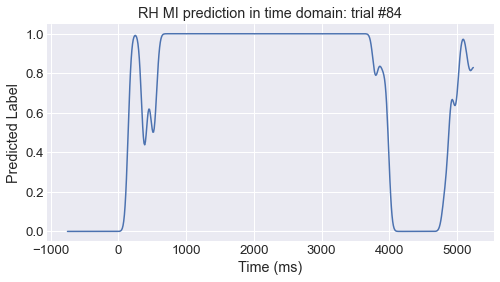

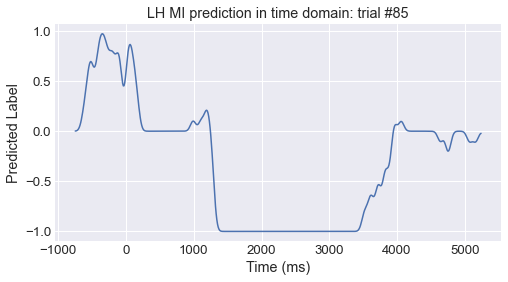

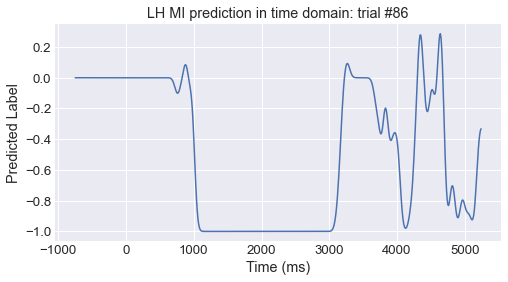

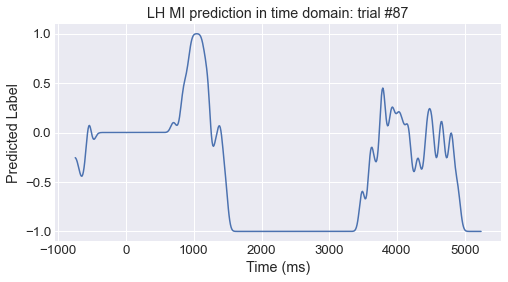

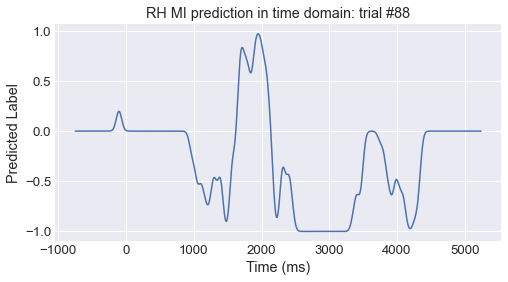

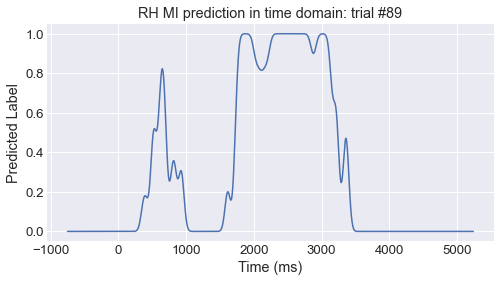

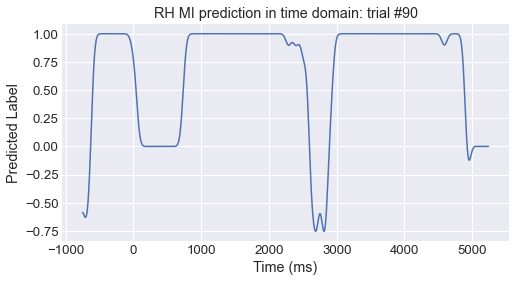

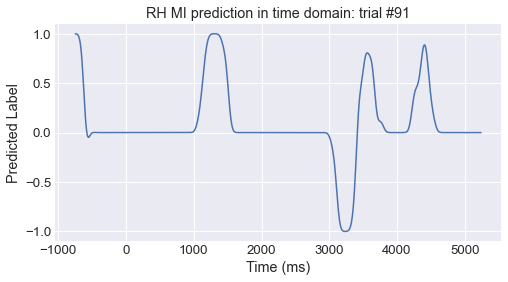

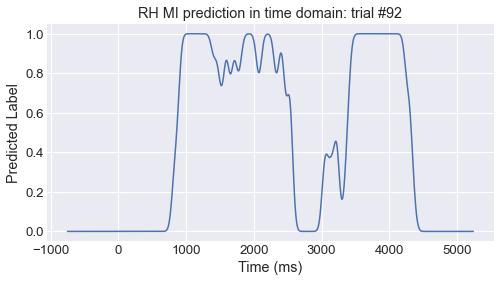

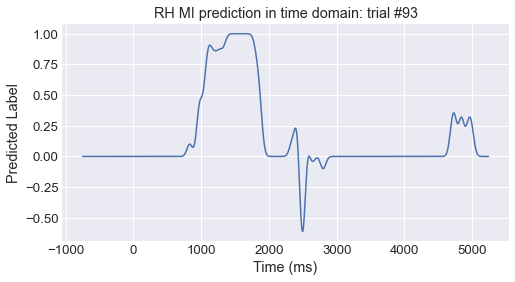

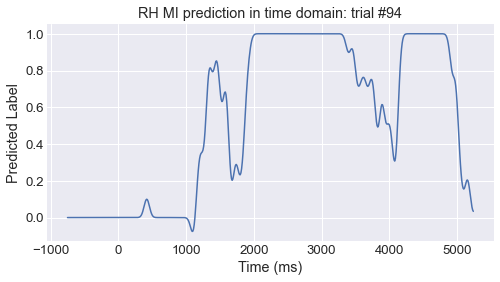

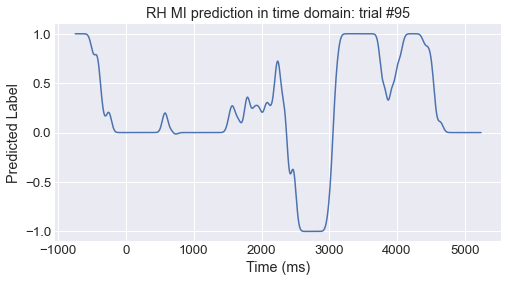

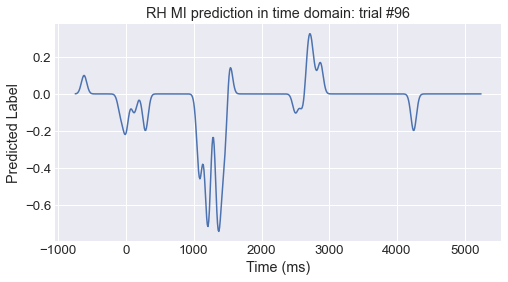

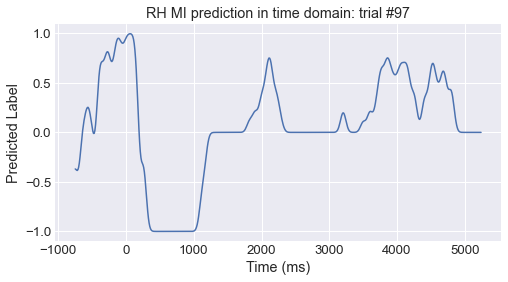

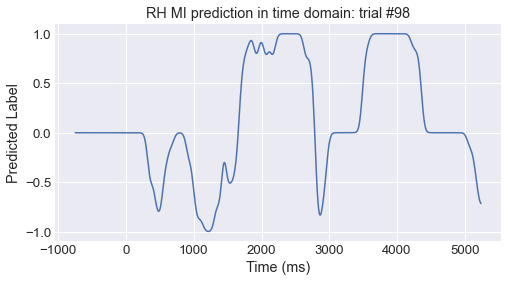

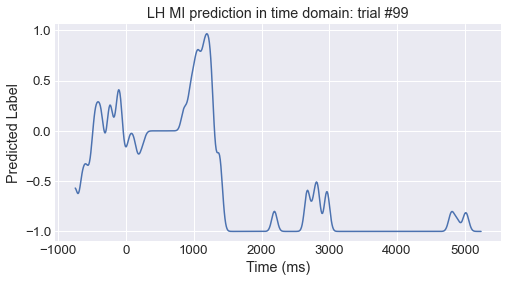

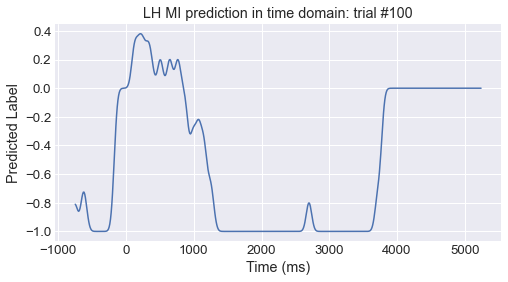

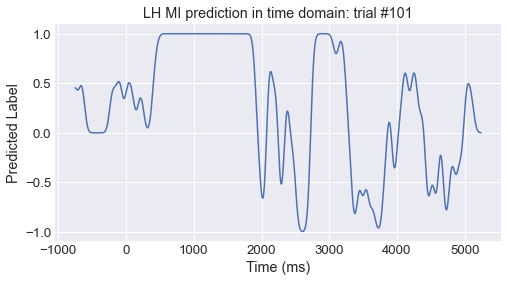

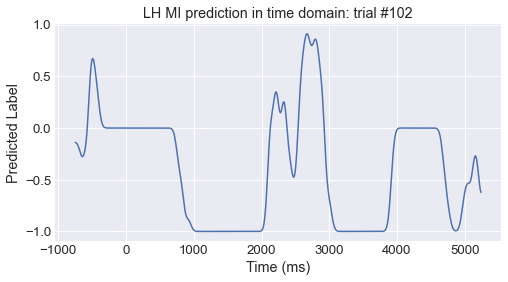

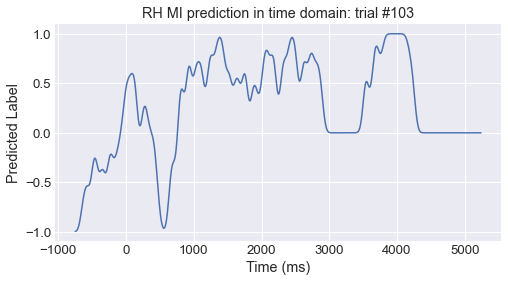

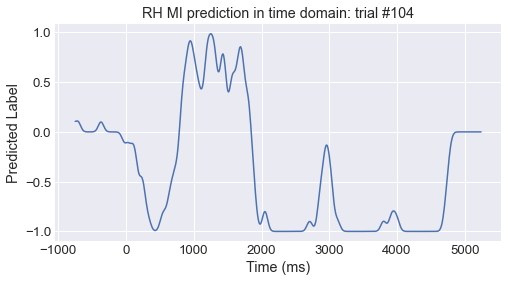

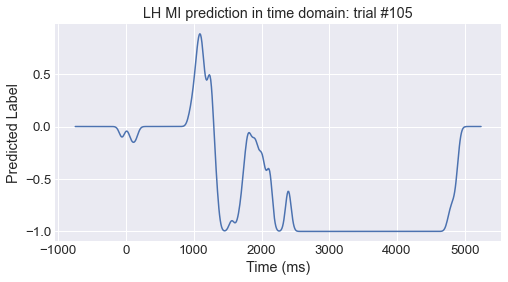

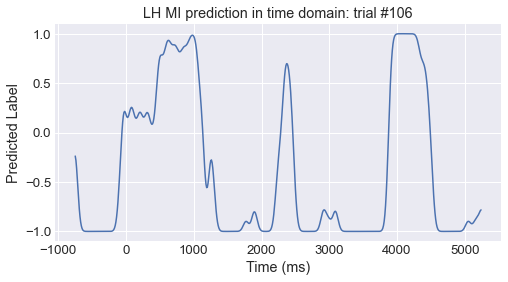

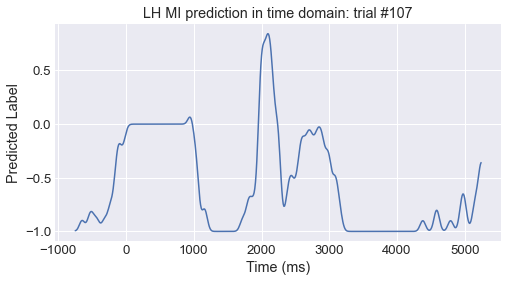

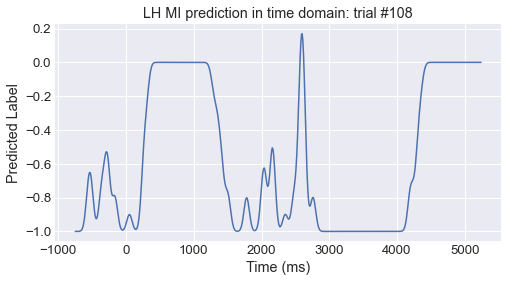

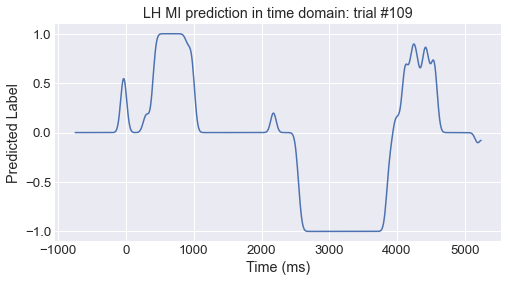

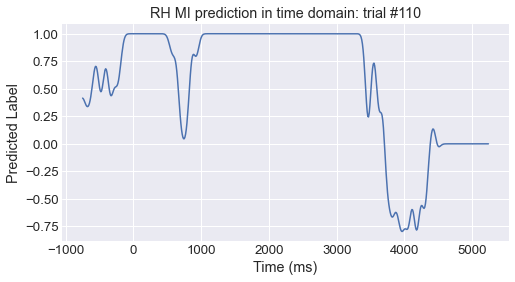

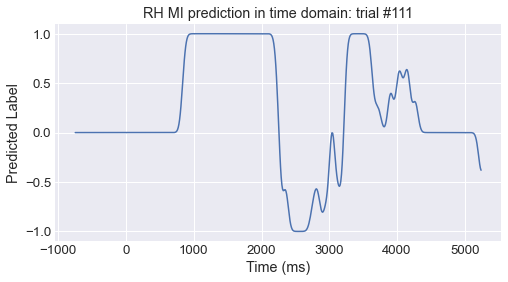

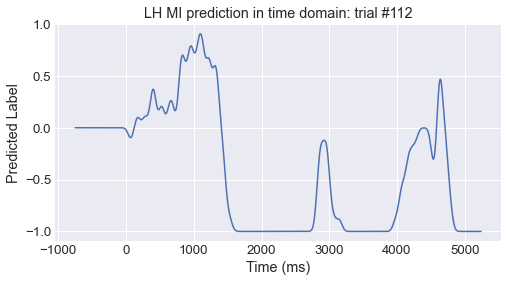

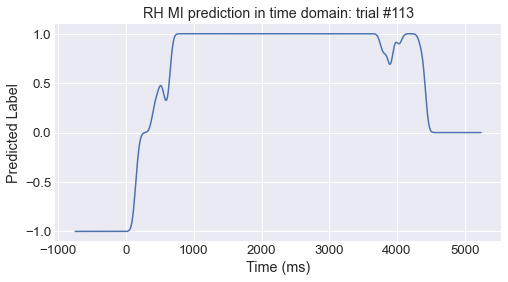

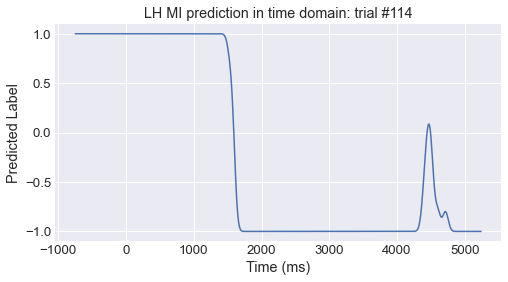

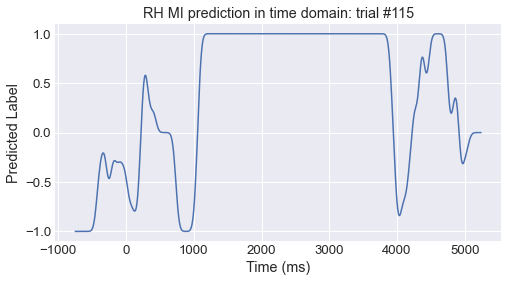

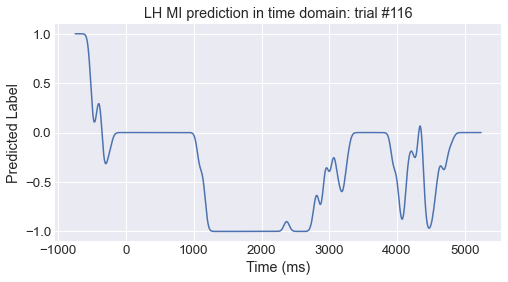

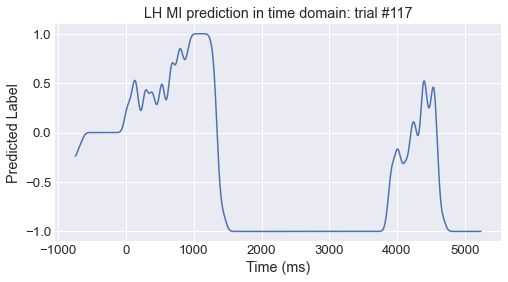

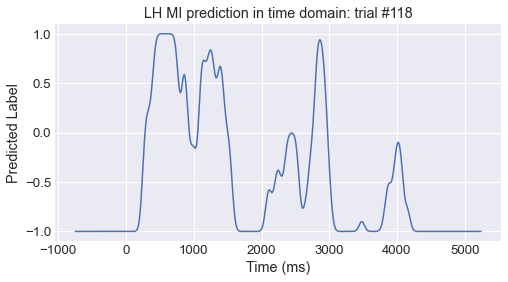

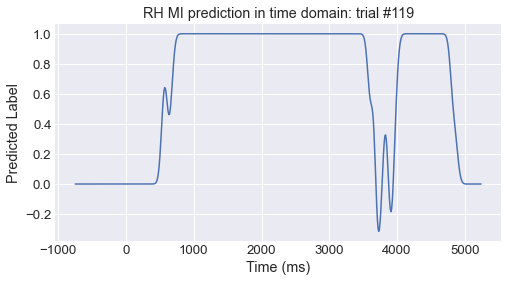

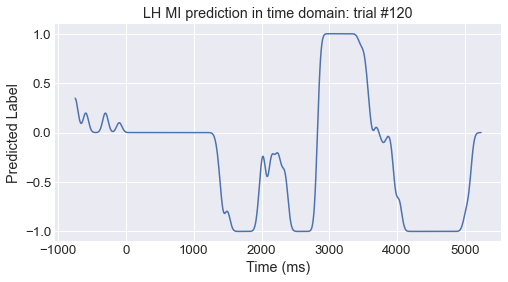

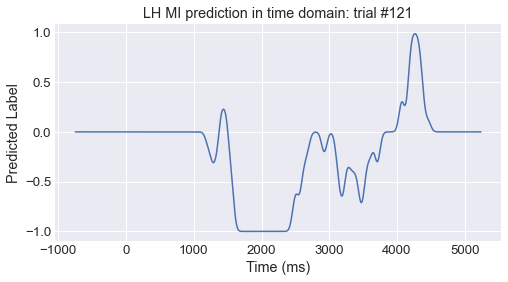

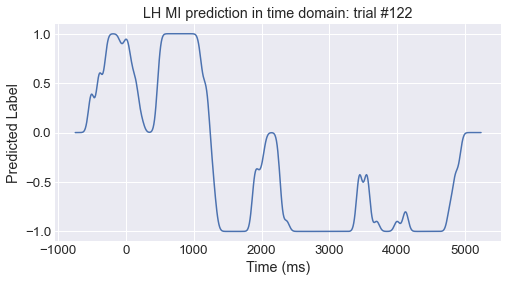

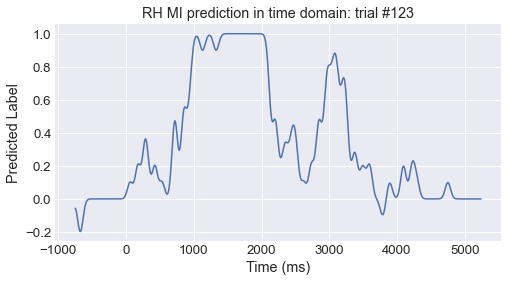

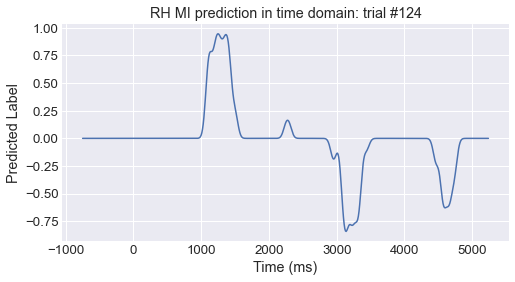

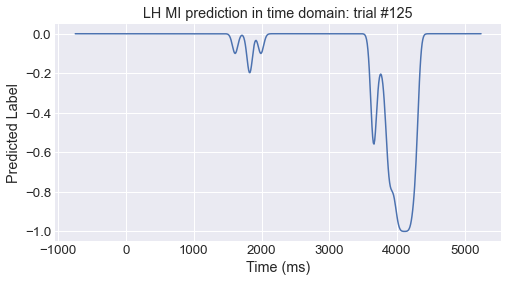

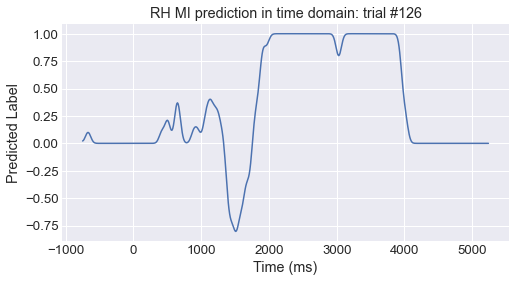

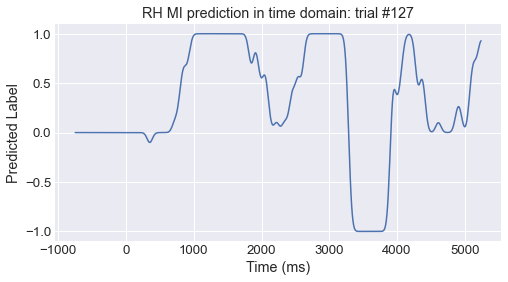

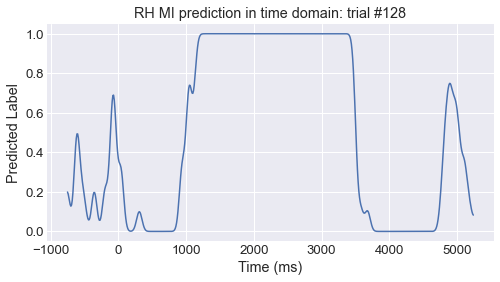

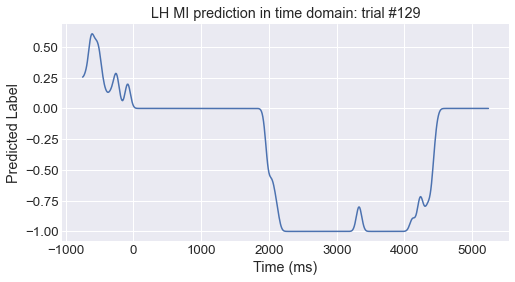

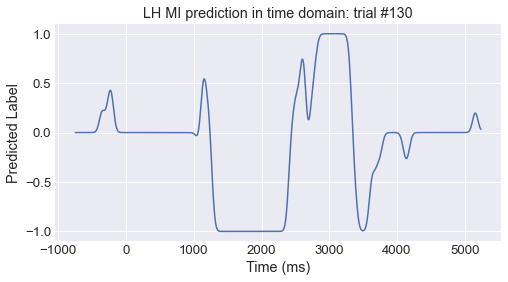

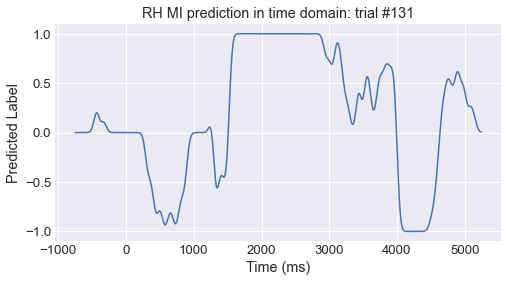

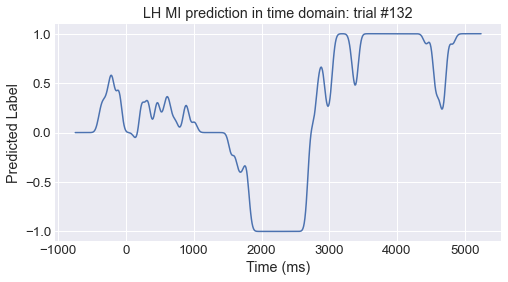

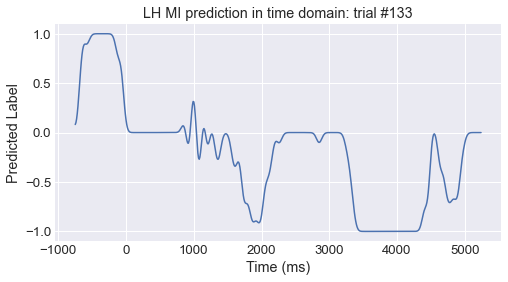

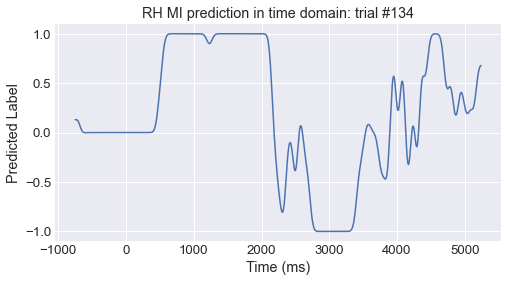

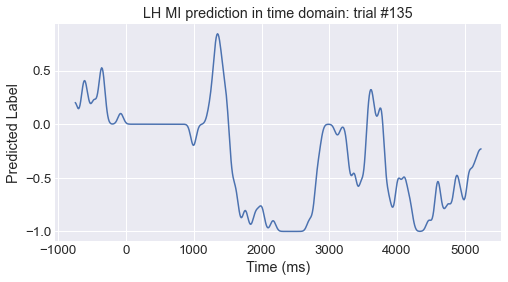

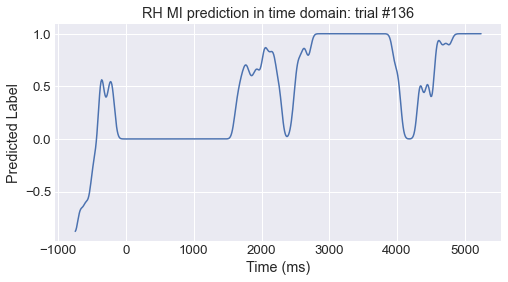

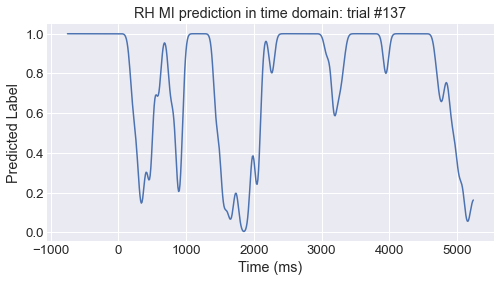

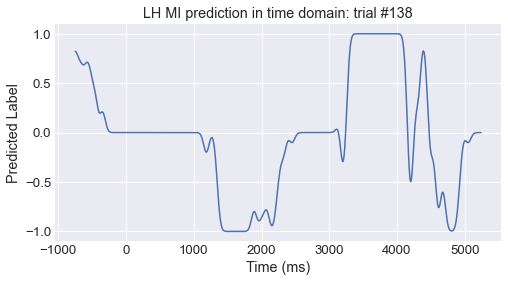

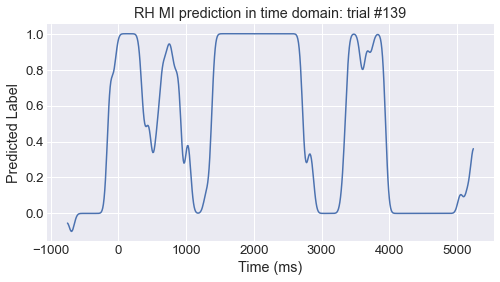

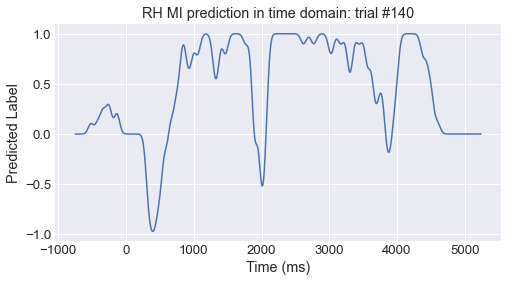

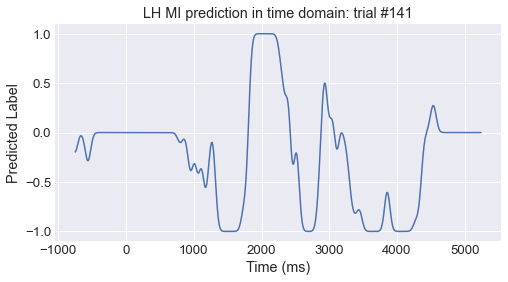

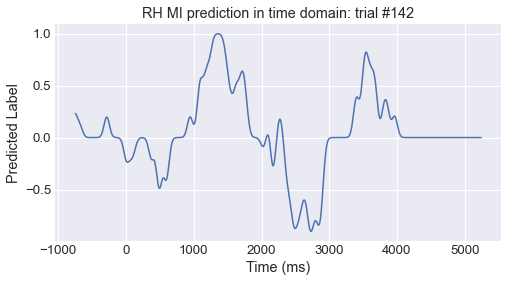

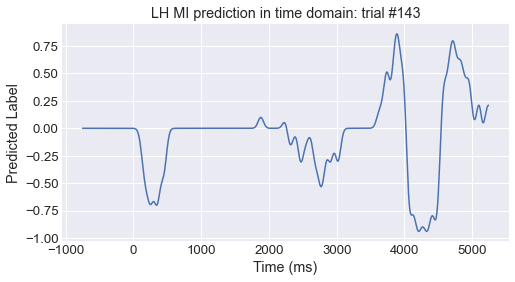

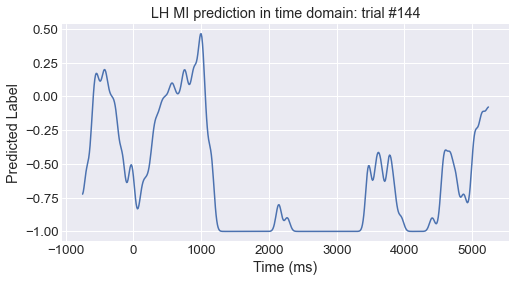

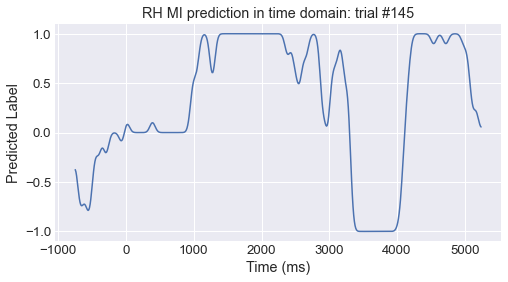

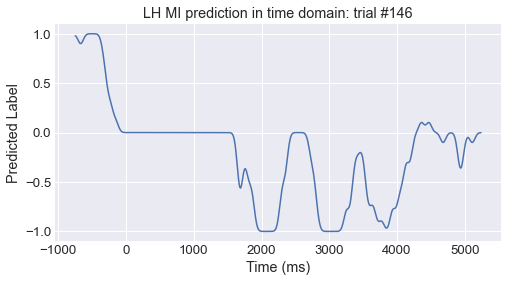

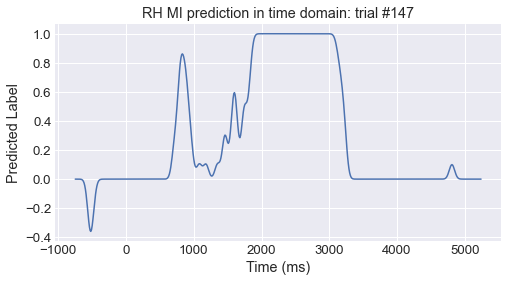

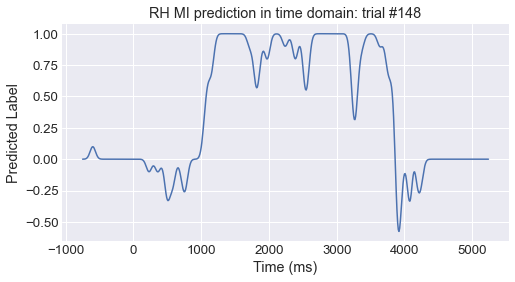

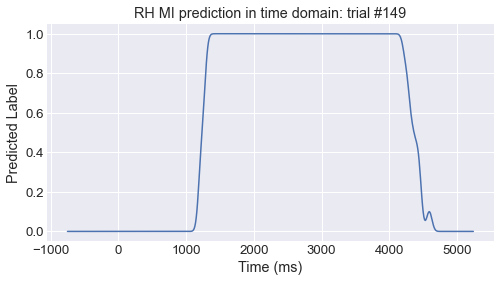

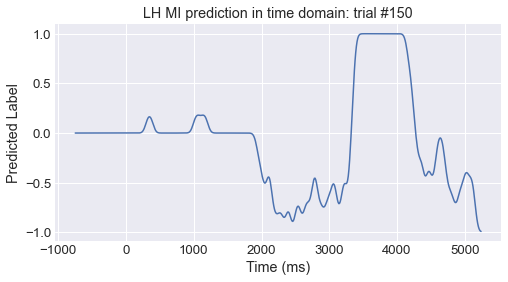

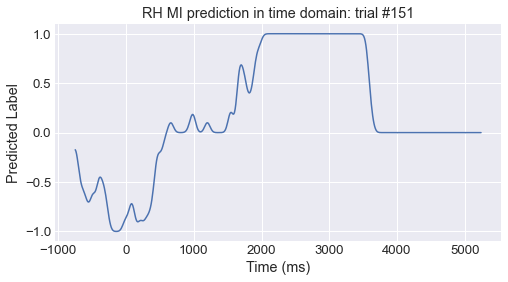

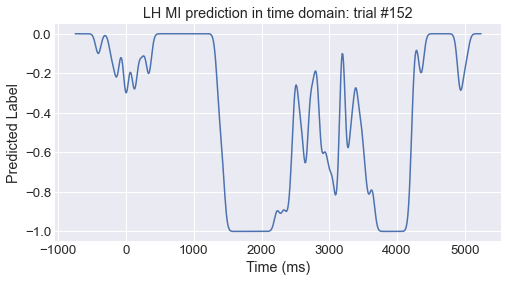

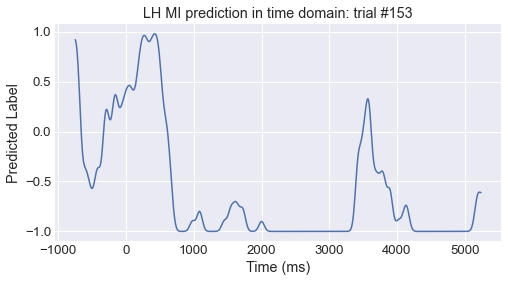

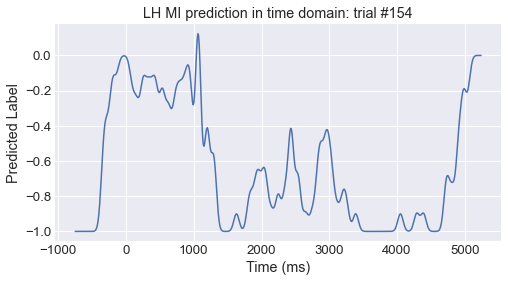

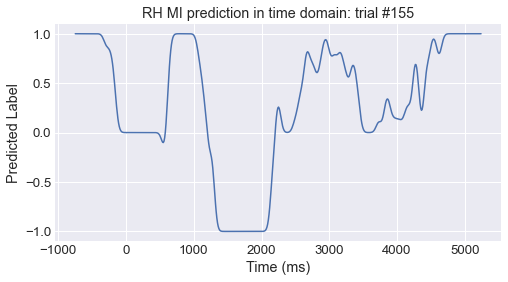

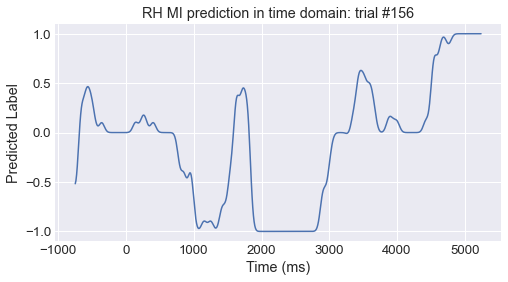

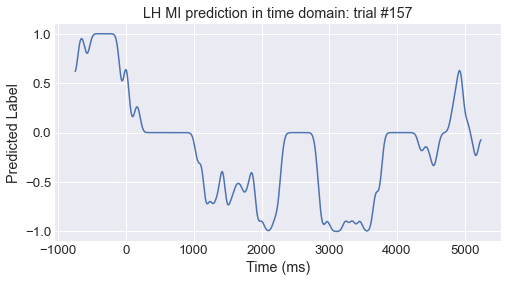

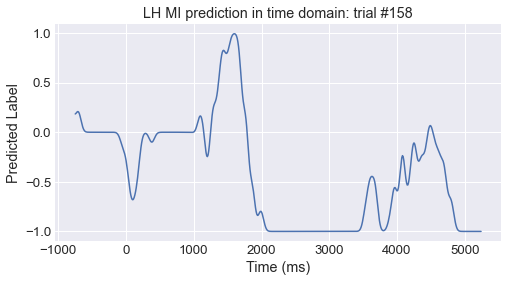

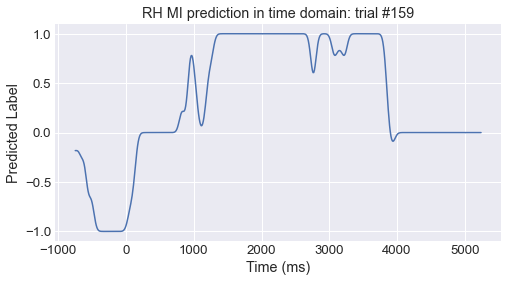

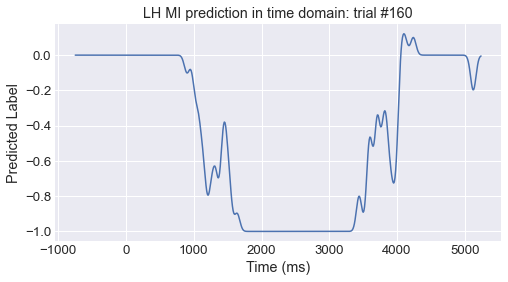

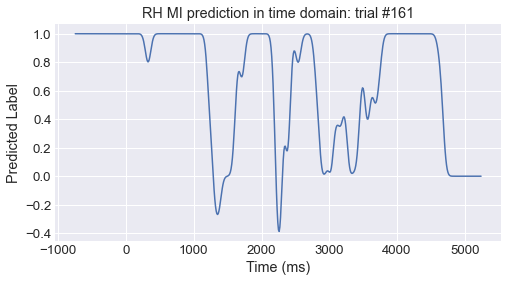

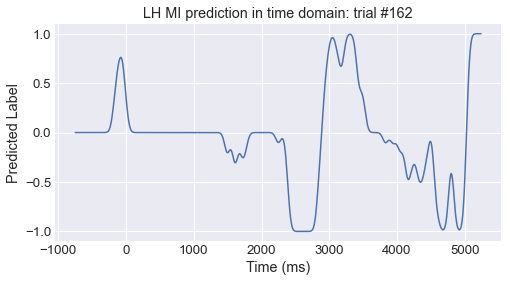

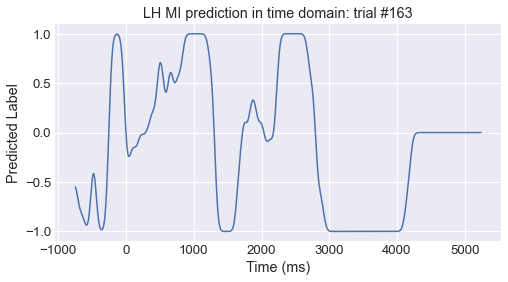

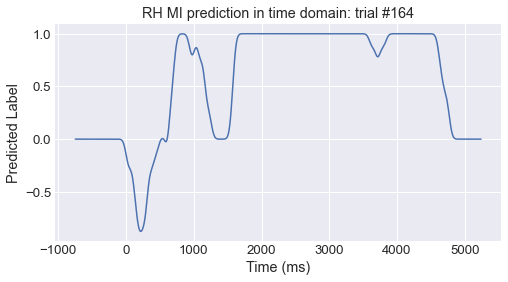

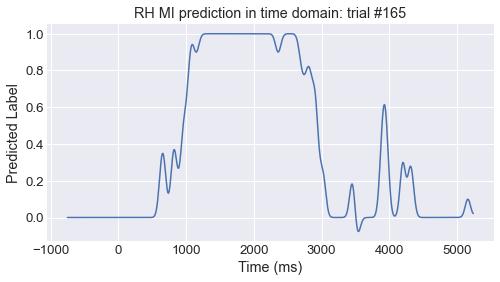

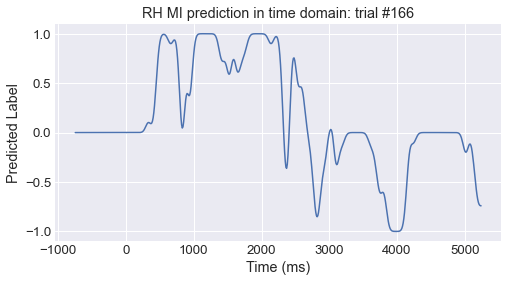

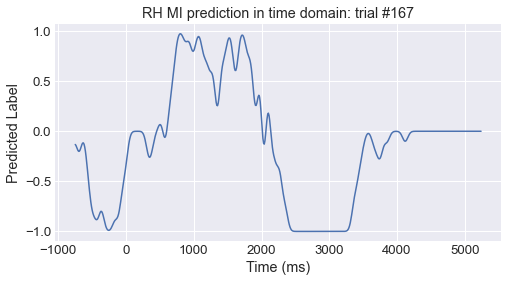

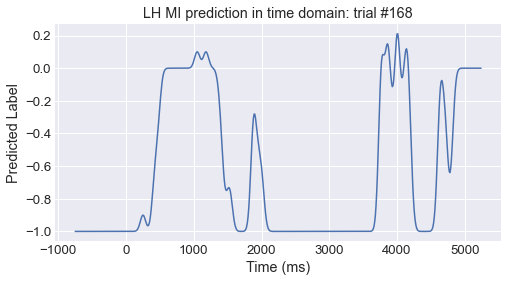

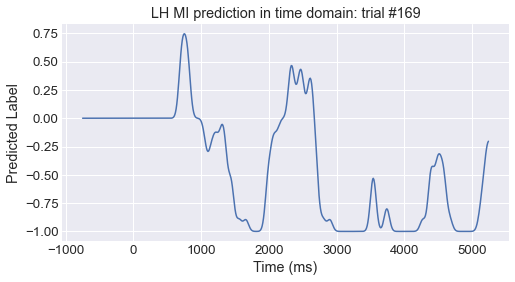

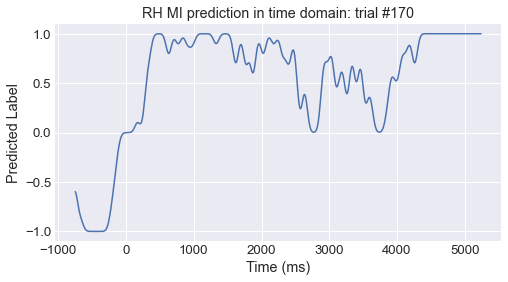

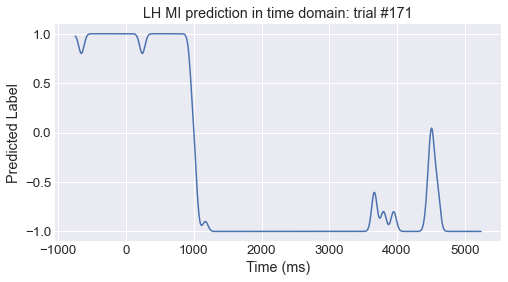

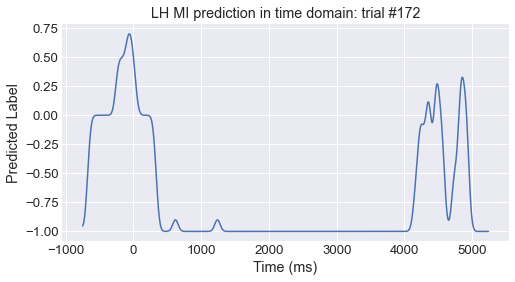

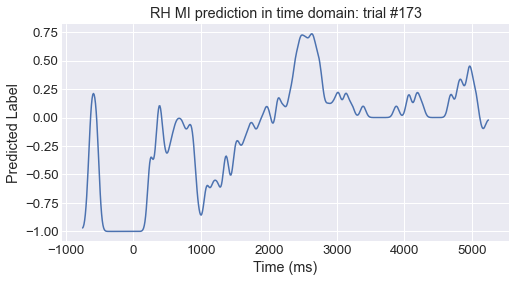

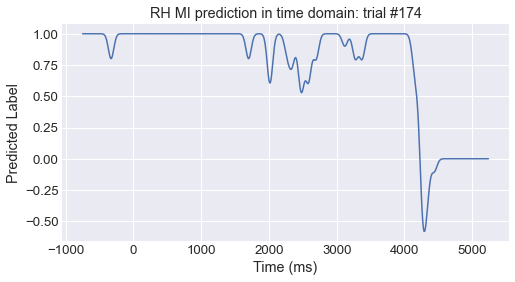

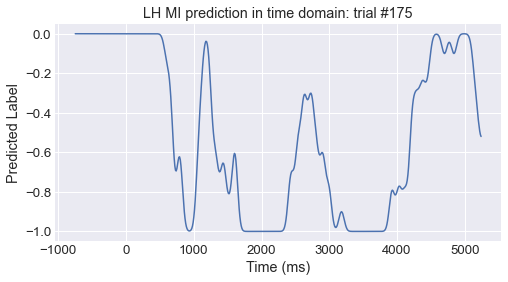

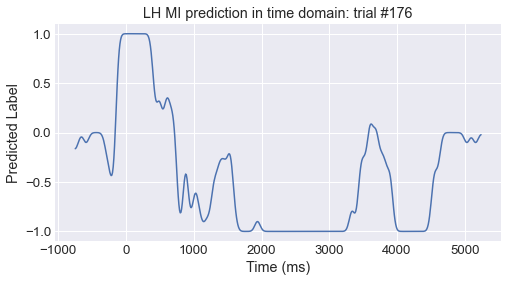

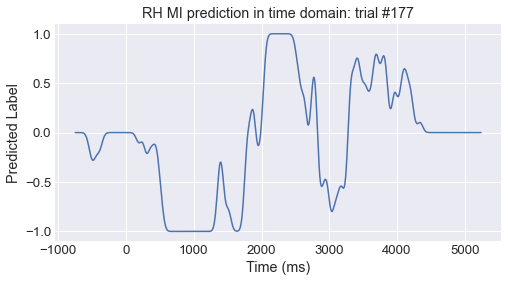

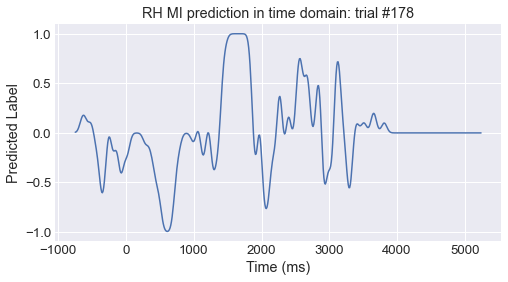

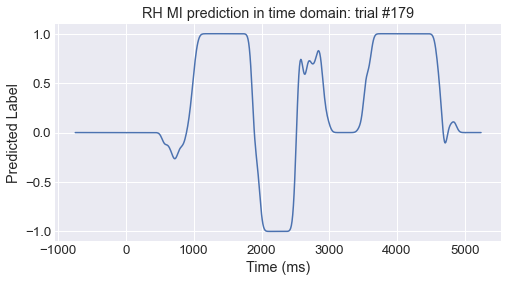

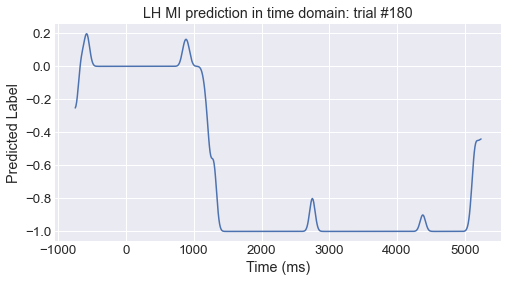

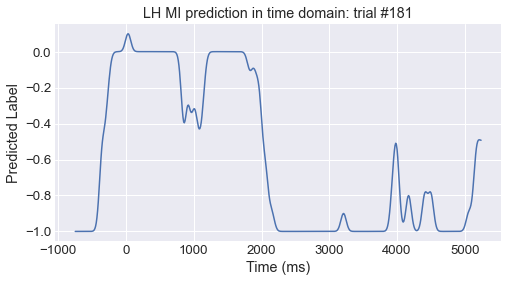

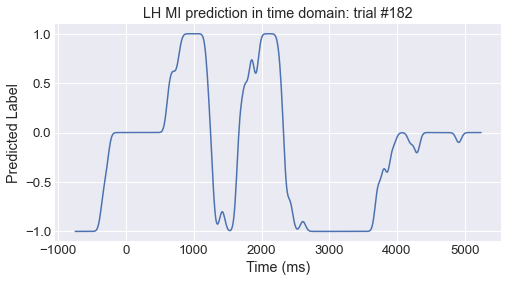

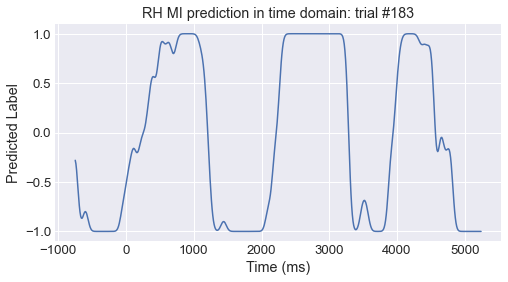

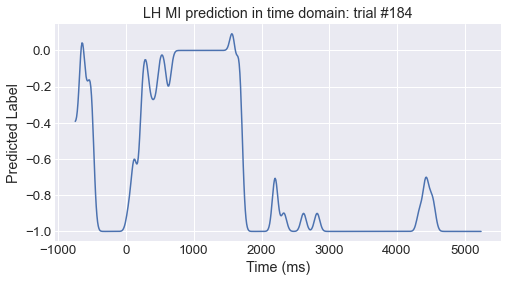

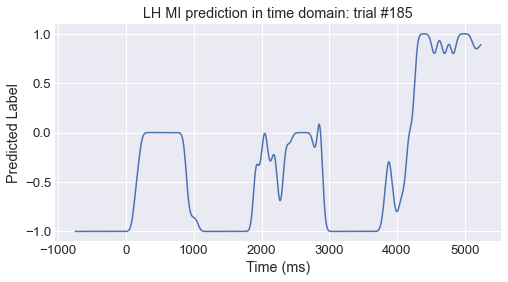

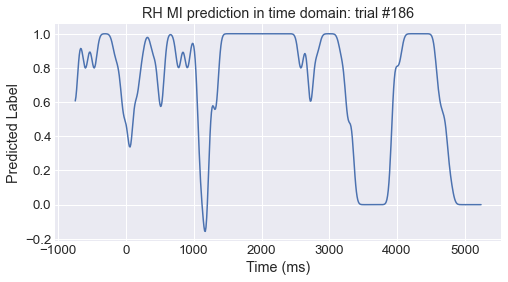

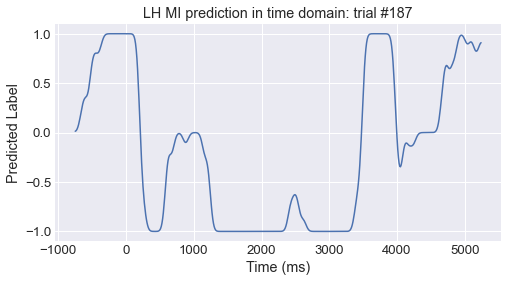

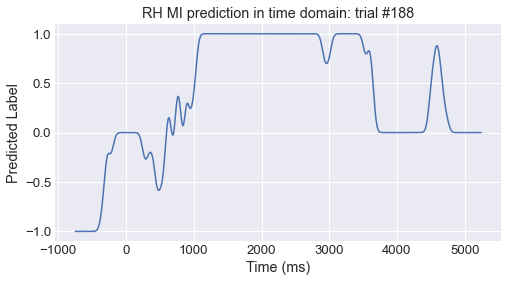

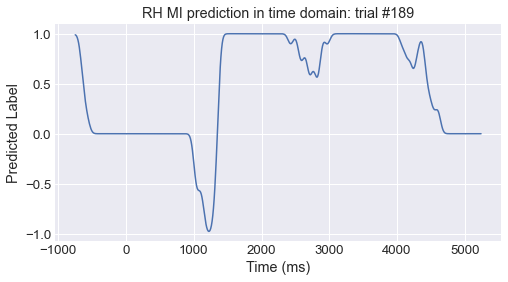

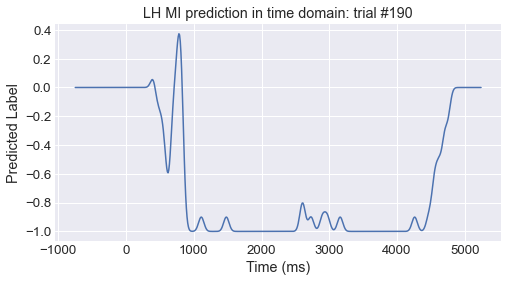

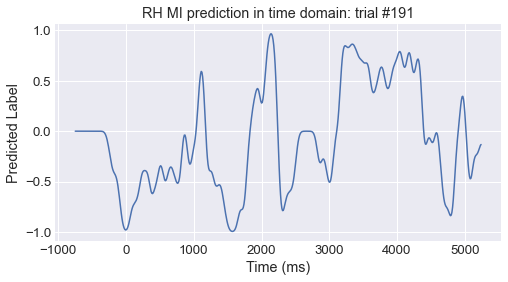

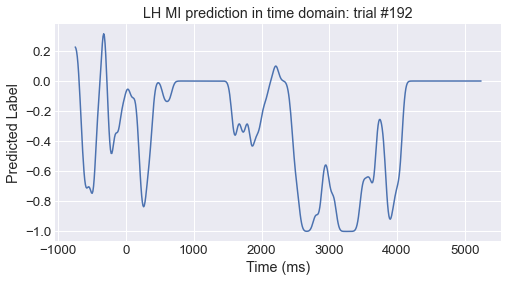

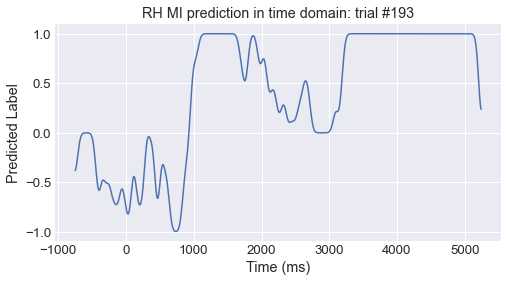

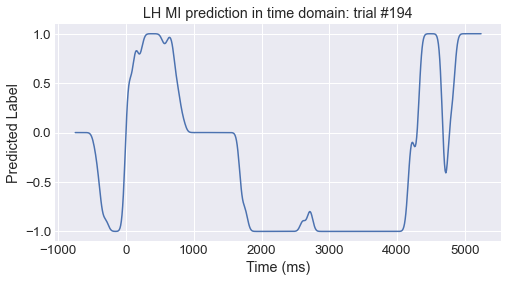

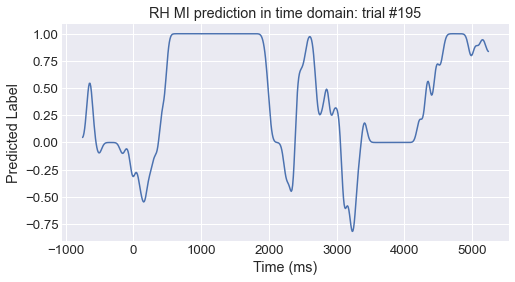

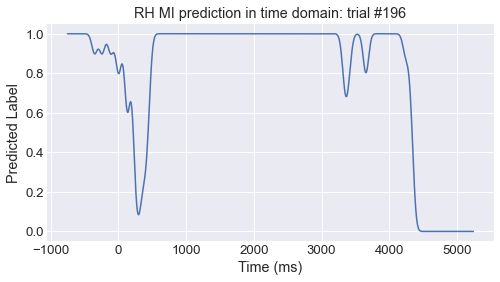

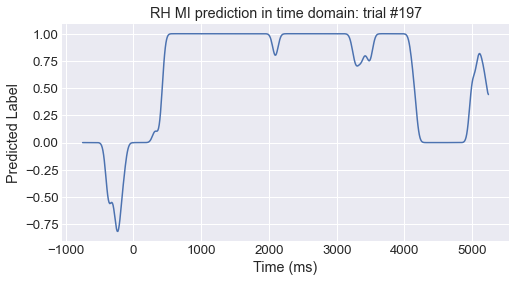

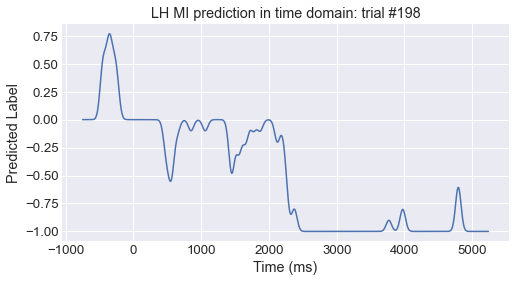

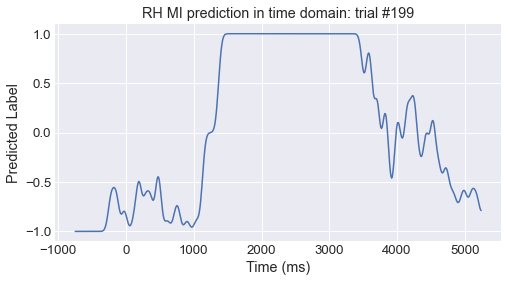

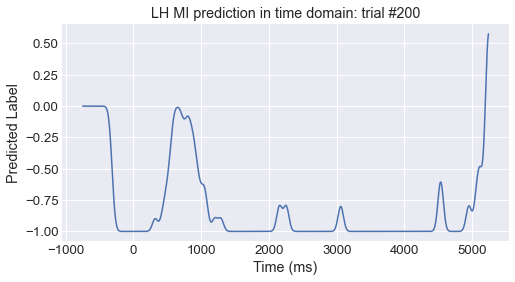

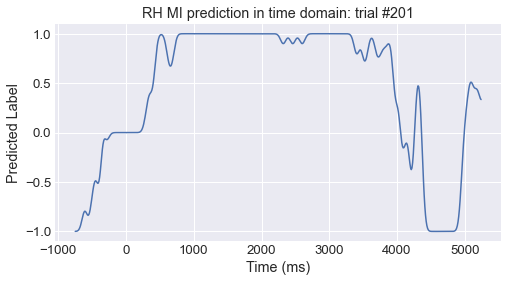

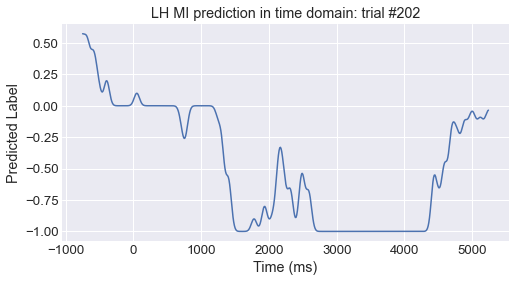

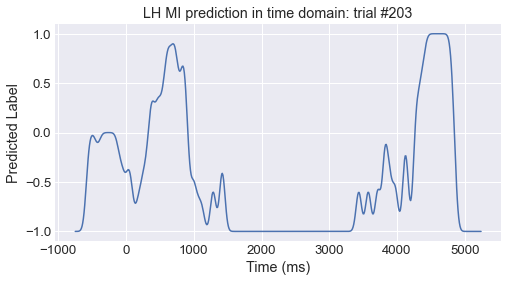

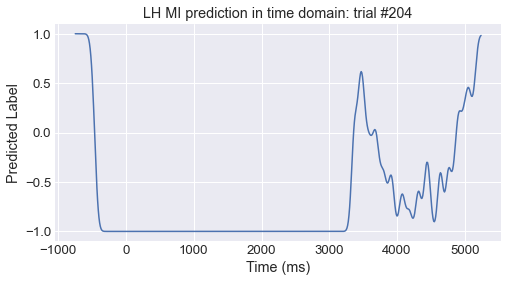

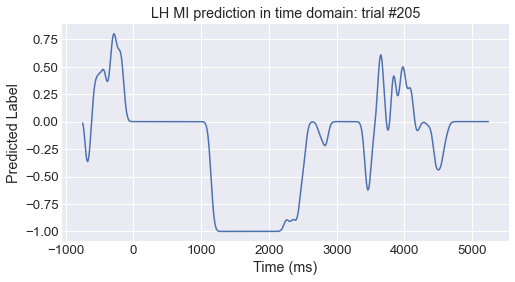

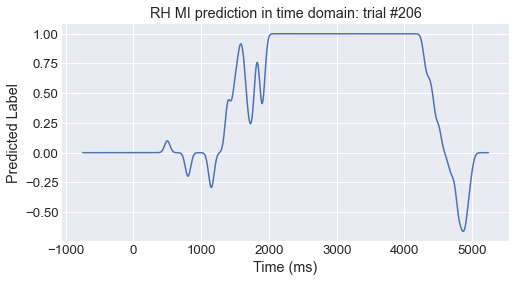

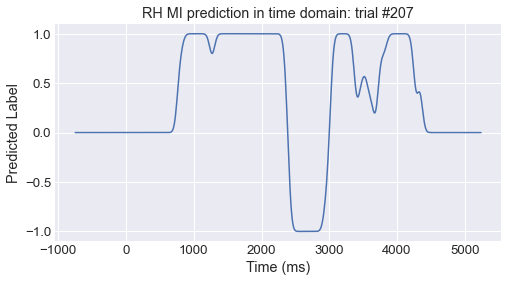

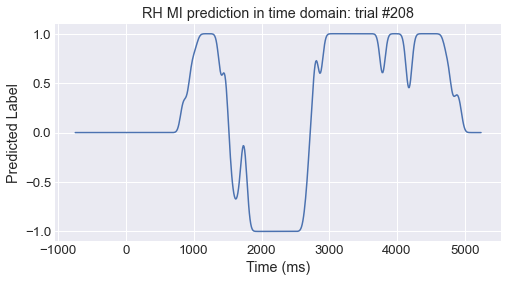

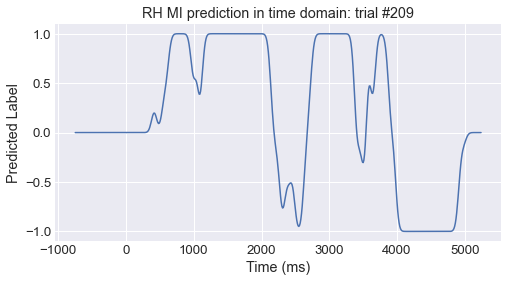

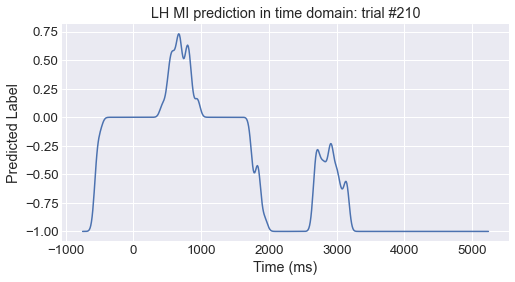

In [110]:
trials = 210

def plot_MI_trials(trials, model, stp):
    x, y = create_data(selected_electrodes, fs, low, high, n_freqs, 210, 1, 0.75, 1, zeros) 
    y = np.array(y)
    
    quantile_transformer = QuantileTransformer(random_state=0).fit(x)
    x_1 = quantile_transformer.transform(x)

    for i in range(trials):
        start = events[i][0]
        trial = selected_electrodes[start-175:start+525, :]
        
        if ((i == 1) or (i == 210)):
            x_train = np.delete(x_1, [i, i+210, i+420], axis=0)
            y_train = np.delete(y, [i, i+210, i+420])
        else:
            x_train = np.delete(x_1, [i, i+210, i+419, i+420], axis=0)
            y_train = np.delete(y, [i, i+210, i+419, i+420])
        
        model.fit(x_train, y_train)
        
        plot_MI_predictions(trial, model, quantile_transformer, stp, i) # stp is in ms
        
        
plot_MI_trials(trials, SVC(kernel='rbf'), 10)

<IPython.core.display.Javascript object>


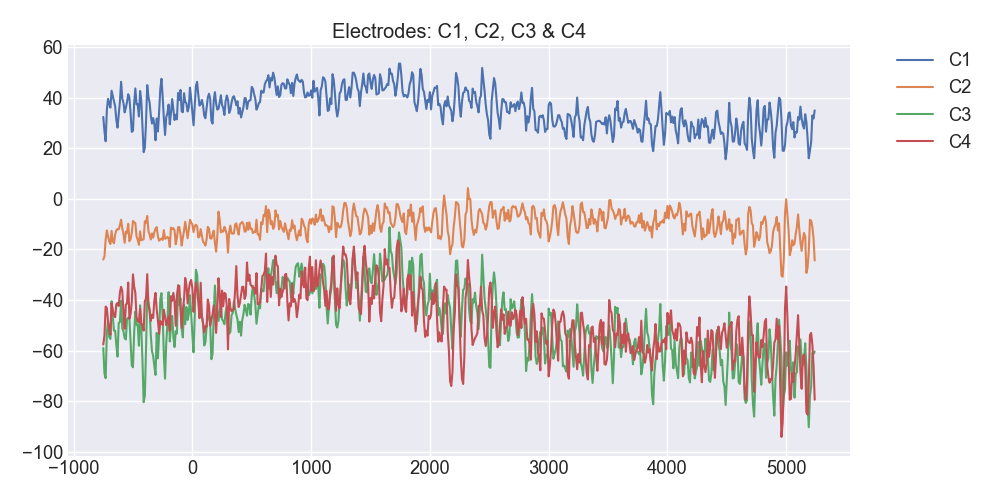

<IPython.core.display.Javascript object>


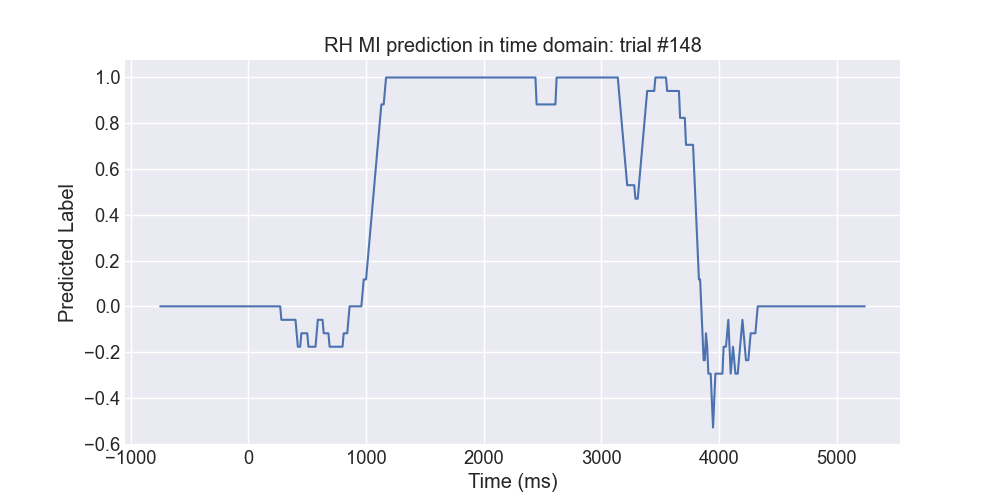

(600,)


In [195]:
trial_148 = selected_electrodes[events[147][0]-175:events[147][0]+525]
time = range(-750, 5250, 10)

sns.set(font_scale=1.2, style='white')
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(time, trial_149)
plt.title("Electrodes: C1, C2, C3 & C4")
plt.legend(['C1', 'C2', 'C3', 'C4'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0) 
plt.tight_layout()

smoothed = plot_MI_predictions(trial_148, model, quantile_transformer, 10, 147) # stp is in ms
print(smoothed.shape)

<IPython.core.display.Javascript object>


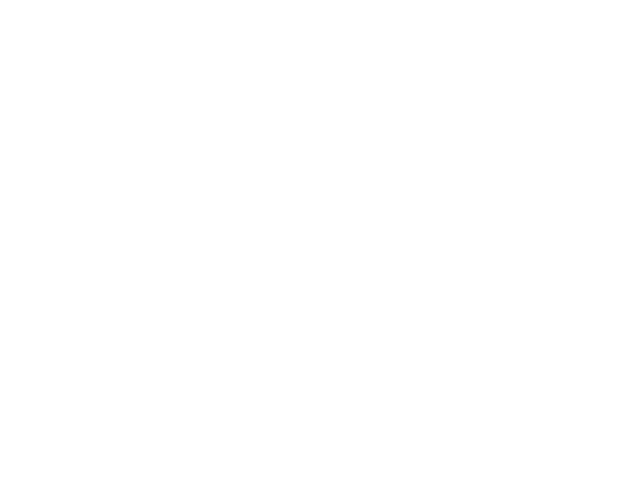

<IPython.core.display.Javascript object>


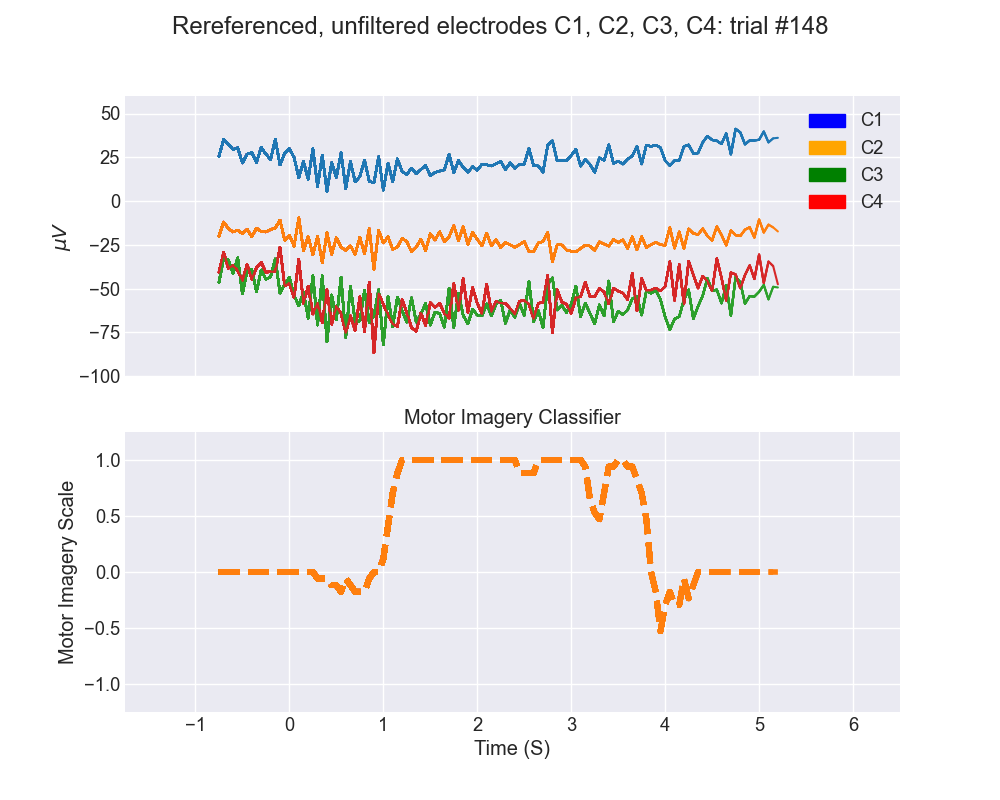

In [202]:
# %%time
from matplotlib.animation import FuncAnimation
import matplotlib.patches as mpatches
from matplotlib import animation
import time

%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

plt.style.use('seaborn-darkgrid')
plt.tight_layout()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
fig.suptitle('Rereferenced, unfiltered electrodes C1, C2, C3, C4: trial #148')
fig.show()


t = []
y1 = []
y2 = []
y3 = []
y4 = []
y5 = []

count = -75
inc = 5

while (count<525):
    t.append(count/100)
    y1.append(trial_148[count+75, 0])
    y2.append(trial_148[count+75, 1])
    y3.append(trial_148[count+75, 2])
    y4.append(trial_148[count+75, 3])
    y5.append(smoothed[count+75])
    
    ax1.set(ylabel=r'$\mu V$')
    ax1.label_outer()
    
    ax2.set_title('Motor Imagery Classifier')
    ax2.set(xlabel='Time (S)', ylabel='Motor Imagery Scale')
    ax2.label_outer()
    
    ax1.plot(t, y1, 'tab:blue')
    ax1.plot(t, y2, 'tab:orange')
    ax1.plot(t, y3, 'tab:green')
    ax1.plot(t, y4, 'tab:red')
    c1 = mpatches.Patch(color='blue', label='C1')
    c2 = mpatches.Patch(color='orange', label='C2')
    c3 = mpatches.Patch(color='green', label='C3')
    c4 = mpatches.Patch(color='red', label='C4')
    ax1.legend(handles=[c1, c2, c3, c4])
    
#     ax1.legend(['C1', 'C2', 'C3', 'C4'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0) 
    ax2.plot(t, y5, 'tab:orange', linewidth=4, linestyle='dashed')
    
    fig.canvas.draw()
    
    ax1.set_xlim(left=-1.75, right=6.5)
    ax1.set_ylim(bottom=-100, top = 60)
    ax2.set_xlim(left=-1.75, right=6.5)
    ax2.set_ylim(bottom=-1.25, top = 1.25)
    
    time.sleep(0.001)
    count += inc

plt.close()